# Intro

## Credits

Credits to the [Competition Notebook](https://colab.research.google.com/drive/1uorVxsO816YOQMbkizlakGC21wS-xVHh#scrollTo=uN03kboJEVSi) on the basis of which we started our data exploration and cleaning (as suggested by Openclassrooms) in order to save us some precious time. 

---


In this notebook, we will take an initial look at the Home Credit default risk machine learning competition currently hosted on Kaggle. The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

## Data

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task. 

There are 7 different sources of data. In this notebook, we will stick to using only the main application training and testing data. Although if we want to have any hope of seriously competing, we need to use all the data, for now we will stick to one file which should be more manageable.

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 

## Evaluation Metric : ROC AUC

Once we have a grasp of the data (reading through the [column descriptions](https://www.kaggle.com/c/home-credit-default-risk/data) helps immensely), we need to understand the metric by which our submission is judged. In this case, it is a common classification metric known as the [Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

The ROC AUC may sound intimidating, but it is relatively straightforward once you can get your head around the two individual concepts. The [Reciever Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) graphs the true positive rate versus the false positive rate:

![image](http://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)

A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model. 

The [Area Under the Curve (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) explains itself by its name! It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generate 0 or 1 predictions, but rather a probability between 0 and 1. This may be confusing because we usually like to think in terms of accuracy, but when we get into problems with inbalanced classes (we will see this is the case), accuracy is not the best metric. For example, if I wanted to build a model that could detect terrorists with 99.9999% accuracy, I would simply make a model that predicted every single person was not a terrorist. Clearly, this would not be effective (the recall would be zero) and we use more advanced metrics such as ROC AUC or the [F1 score](https://en.wikipedia.org/wiki/F1_score) to more accurately reflect the performance of a classifier. A model with a high ROC AUC will also have a high accuracy, but the [ROC AUC is a better representation of model performance.](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy)

Now that we know the background of the data we are using and the metric to maximize, let's get into exploring the data. In this notebook, as mentioned previously, we will stick to the main data sources and simple models which we can build upon in future work. 

# Import

In [1]:
#install packages
!pip install shap
!pip install sklearn-pandas

     |████████████████████████████████| 564 kB 5.1 MB/s 


In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn_pandas import DataFrameMapper

from sklearn.model_selection import *
import sklearn.metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFECV
from sklearn.metrics import fbeta_score, make_scorer

#explainability
import shap

In [3]:
#Prevent truncation
pd.set_option('display.max_colwidth', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan. 

In [5]:
# List files available
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/3_Projets OC/Projet 7/raw_data/Projet+Mise+en+prod+-+home-credit-default-risk'))

['HomeCredit_columns_description.csv', 'credit_card_balance.csv', 'bureau_balance.csv', 'POS_CASH_balance.csv', 'application_test.csv', 'bureau.csv', 'installments_payments.csv', 'sample_submission.csv', 'previous_application.csv', 'application_train.csv']


In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/3_Projets OC/Projet 7/raw_data/Projet+Mise+en+prod+-+home-credit-default-risk'

# Training data
app_train = pd.read_csv(path + '/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

In [7]:
# Testing data features
app_test = pd.read_csv(path + '/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The test set is considerably smaller and lacks a `TARGET` column. 

As this dataset has been used for a kaggle competition, testing set allows lack the target info. Competitors build models on training set then test it on the testing set (lacking the target column) and submit the prediction on Kaggle platform. The performance score is then obtained by comparing predictions to target. 

# EDA

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

## Target column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [8]:
target_count = app_train['TARGET'].value_counts()

In [9]:
print('Class 0 (Repaid) :', target_count[0])
print('Class 1 (Default) :', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

Class 0 (Repaid) : 282686
Class 1 (Default) : 24825
Proportion: 11.39 : 1


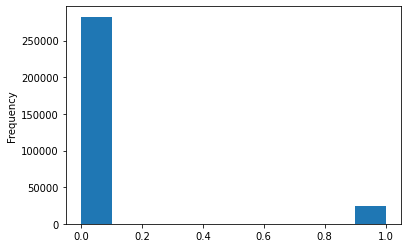

In [10]:
app_train['TARGET'].astype(int).plot.hist();

From this information, we see this is an [_imbalanced class problem_](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models (e.g in XGBOOST with hparam: `scale_pos_weight`), we can [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) by their representation in the data to reflect this imbalance. 

## Missing values

In [11]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [12]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can [handle missing values with no need for imputation](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. 

**Therefore, we will keep all of the columns for now.**

## Column types

Let's look at the number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) . 

In [13]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [14]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables! 

## Encoding Categorical Variables

Before we go any further, we need to deal with pesky categorical variables.  A machine learning model unfortunately cannot deal with categorical variables (except for some models such as [LightGBM](http://lightgbm.readthedocs.io/en/latest/Features.html)). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns. 

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

There is some debate about the relative merits of these approaches, and some models can deal with label encoded categorical variables with no issues. [Here is a good Stack Overflow discussion](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). I think (and this is just a personal opinion) for categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by [PCA](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) or other [dimensionality reduction methods](https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/) to reduce the number of dimensions (while still trying to preserve information). 

**In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories.**

This process may need to change as we get further into the project, but for now, we will see where this gets us. (We will also not use any dimensionality reduction in this notebook but will explore in future iterations).

In [15]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [16]:
app_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE              int64
CODE_GENDER                    object
FLAG_OWN_CAR                    int64
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [17]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
# app_train = pd.get_dummies(app_train)

print('Training Features shape: ', app_train.shape)
# print('Testing Features shape: ', X_test.shape)

Training Features shape:  (307511, 243)


## Align dataframe

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to `align` the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set `axis = 1` to align the dataframes based on the columns and not on the rows!

In [18]:
#update : we will only consider app_train so no alignment is needed

# train_labels = app_train['TARGET']

# # Align the training and testing data, keep only columns present in both dataframes
# X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)

# # Add the target back in
# # app_train['TARGET'] = train_labels

# print('Training Features shape: ', X_train.shape)
# print('Testing Features shape: ', X_test.shape)

The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) to reduce the size of the datasets.

**As we are not part of the Kaggle Competition, we will only use the train_app as our full labeled dataset. No need for alignment.**

But keeping it as a reminder of this good practice for Kaggle Competition. 

## Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `describe` method. 

The numbers in the `DAYS_BIRTH` column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:


In [19]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [20]:
(app_train['DAYS_EMPLOYED'] / 365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years! 

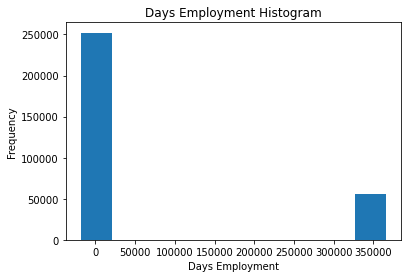

In [21]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [22]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default. 

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (`np.nan`) and then create a new boolean column indicating whether or not the value was anomalous.

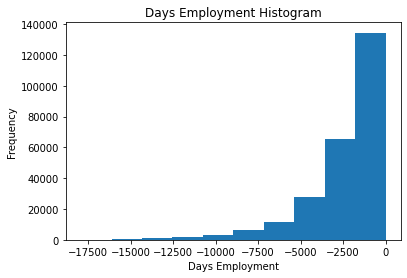

In [23]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (because we will have to fill in the nans with some value, probably the median of the column). The other columns with `DAYS` in the dataframe look to be about what we expect with no obvious outliers. 


*N/A as we are not part of Kaggle Competition*: As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with `np.nan` in the testing data. 

## Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”

In [24]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` is the most positive correlation. (except for `TARGET` because the correlation of a variable with itself is always 1!) Looking at the documentation, `DAYS_BIRTH` is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

## Age Effect

In [25]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. 

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

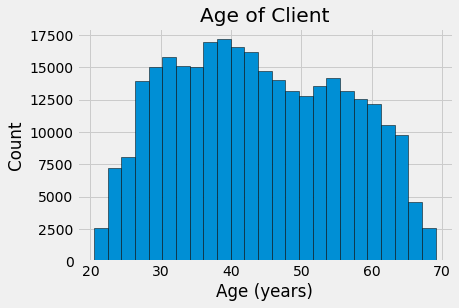

In [26]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a [kernel density estimation plot](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) colored by the value of the target. A [kernel density estimate plot shows the distribution of a single variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn `kdeplot` for this graph.

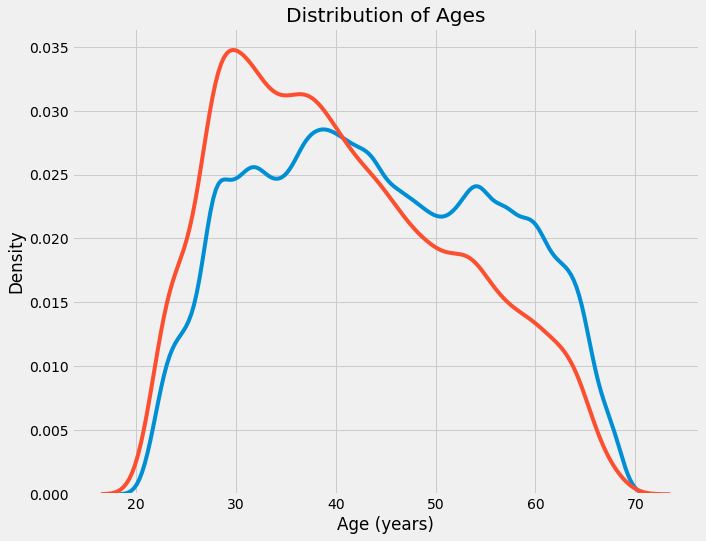

In [27]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket. 

To make this graph, first we `cut` the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [28]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [29]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


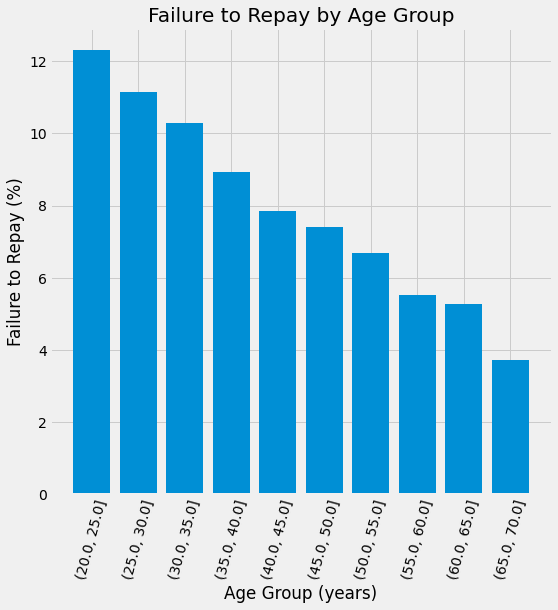

In [30]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

## External sources


The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data. 

Let's take a look at these variables.

First, we can show the correlations of the `EXT_SOURCE` features with the target and with each other.

In [31]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


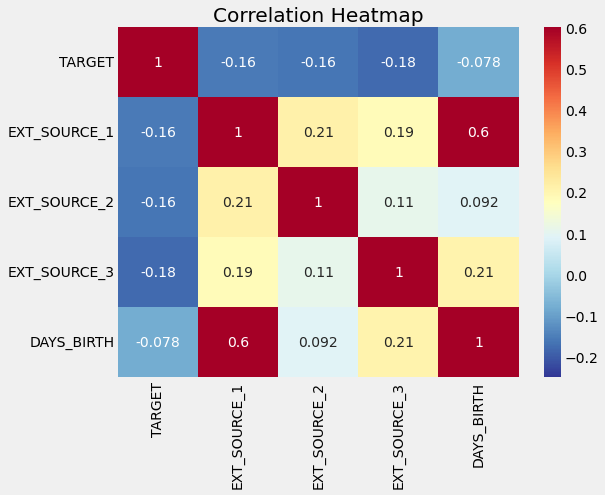

In [32]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three `EXT_SOURCE` features have negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. 

We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

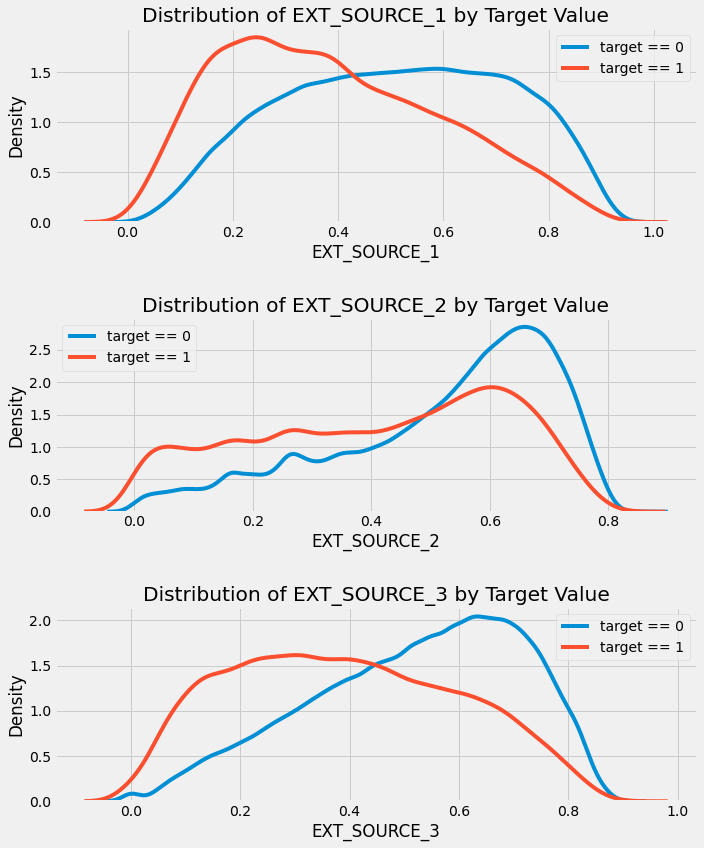

In [33]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

    plt.legend()
    
plt.tight_layout(h_pad = 2.5) 

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all [considered very weak](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

## Pair Plot

As a final exploratory plot, we can make a pairs plot of the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. The [Pairs Plot](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

If you don't understand this code, that's all right! Plotting in Python can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)! 

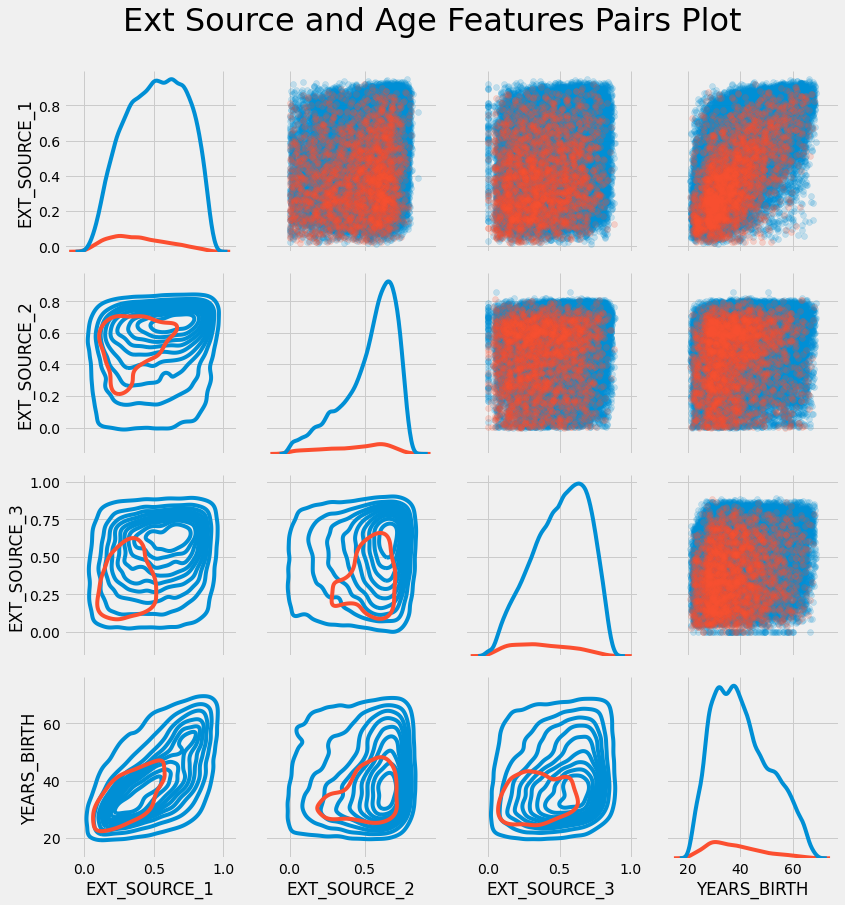

In [34]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the `EXT_SOURCE_1` and the `DAYS_BIRTH` (or equivalently `YEARS_BIRTH`), indicating that this feature may take into account the age of the client. 

# (Modeling)

## Pre-processing

- Split train-test
- Encoding (done above)
- Scaling
- Imputing missing values (median)

We split the train_app to obtain a training and a testing set. 

As the dataset size is quite big, we will use a stratitified sample to train our models. We split twice the data while using the `stratified` parameters to obtain our sample. 


In [35]:
X_train, X_test, y_train, y_test = train_test_split(app_train.drop(['TARGET'], axis=1), #x
                                                    app_train['TARGET'], #y
                                                    test_size=0.2,
                                                    stratify=app_train['TARGET'], #stratified sample
                                                    random_state=123)

In [36]:
X_unused, X_train_sample, y_train_unused, y_train_sample = train_test_split(X_train, 
                                                                            y_train, #y
                                                                            test_size=0.1,
                                                                            stratify=y_train, #stratified sample
                                                                            random_state=123)

print(f'Size of Stratified sample :{X_train_sample.shape}')
print(f'As a % of training set :{(X_train_sample.shape[0] / X_train.shape[0]) * 100}')

Size of Stratified sample :(24601, 243)
As a % of training set :10.000081298169166


In [37]:
#encoding already done 
  #Label encoding when < = 2 modalities per features
  #Dummy for the rest

#missing values
imputer = SimpleImputer(strategy="median")

#standardisation
scaler = StandardScaler()

#Transformation Pipeline
pipeline = Pipeline(steps=[
                     ('imputer', imputer),
                     ('scaler', scaler)
])

X_train_tr = pipeline.fit_transform(X_train_sample)
X_test_tr = pipeline.transform(X_test)

## Performance Metrics

One of the major issues when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy_score can be misleading. 

In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory. This is why, as suggested in the introduction of this notebook, we will use the `roc_auc` as the `scoring` hyperparameter of our `GridSearchCV`. 

We want to predict the probabilities of not paying a loan, so we use the model `predict.proba` method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

In [38]:
def train_test(model, tuned_parameters, x_train, x_test, y_train, y_test):
  
  #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
  #https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308256-evaluez-un-algorithme-de-classification-qui-retourne-des-valeurs-binaires

  clf = GridSearchCV(model, 
                    param_grid=tuned_parameters, 
                    scoring='roc_auc', 
                    refit='roc_auc',
                    cv=5,
                    return_train_score=True
                    )
  clf.fit(x_train, y_train)
  roc_auc_score_train = round(clf.best_score_,4)
  
  y_pred_proba = clf.best_estimator_.predict_proba(x_test) 
  y_pred_proba = y_pred_proba[:, 1]
  threshold = 0.5
  y_pred = y_pred_proba > threshold
  y_pred = y_pred.astype(int)

  #confusion matrix from predictions
  print(f'Confusion Matrix from predictions for {model} :')
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.grid(False)
  plt.show()
  print()

  #performance metrics on test set
  recall_score = round(sklearn.metrics.recall_score(y_test, y_pred),4)
  f1_score = round(sklearn.metrics.f1_score(y_test, y_pred),4)
  roc_auc_score = round(sklearn.metrics.roc_auc_score(y_test, y_pred_proba),4)

  #return (i) perf metrics (ii) best hyperparams
  print(f'Performance Metrics for {model} :')
  print(f'Recall/sensitivity [true positive rate = TP / (TP + FN)]: {recall_score}')
  print(f'F1 Score : {f1_score}')
  print(f'AUROC : {roc_auc_score}')
  print()
  
  print(f'Best Hyperparam(s) on training set :{clf.best_params_}')

  # store results in a dataframe
  df_results = pd.DataFrame(columns=['Model',
                                     'best_params_', 
                                     'roc_auc_score_train', 
                                     'roc_auc_score_test', 
                                     'recall_score_test',
                                     'f1_score_test'
                                     ])

  data = {'Model': [model], 
          'best_params_' : [clf.best_params_], 
          'roc_auc_score_train' : [roc_auc_score_train],
          'roc_auc_score_test' : [roc_auc_score],
          'recall_score_test' : [recall_score], 
          'f1_score_test': [f1_score] 
          }

  results = pd.DataFrame.from_dict(data)

  df_results = df_results.append(results)

  return df_results

## Baseline

Confusion Matrix from predictions for DummyClassifier() :


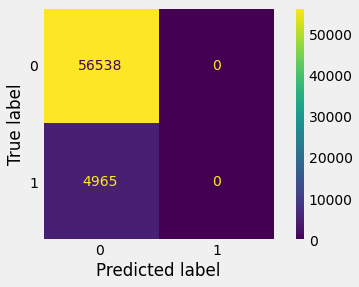


Performance Metrics for DummyClassifier() :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.0
F1 Score : 0.0
AUROC : 0.5

Best Hyperparam(s) on training set :{}


In [39]:
model = DummyClassifier()

tuned_parameters = {}

df_results_baseline = train_test(model,
                                 tuned_parameters,
                                 X_train_tr,
                                 X_test_tr,
                                 y_train_sample,
                                 y_test)

## Logistic Regression

We will use [`LogisticRegression` from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for our first model. The only change we will make from the default model settings is to lower the [regularization parameter](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default `LogisticRegression`, but it still will set a low bar for any future models.

Confusion Matrix from predictions for LogisticRegression() :


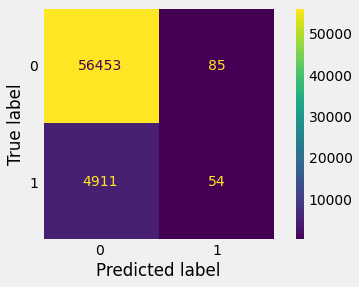


Performance Metrics for LogisticRegression() :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.0109
F1 Score : 0.0212
AUROC : 0.7279

Best Hyperparam(s) on training set :{'C': 0.005}


In [40]:
model = LogisticRegression()

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log = train_test(model,
                            tuned_parameters,
                            X_train_tr,
                            X_test_tr,
                            y_train_sample,
                            y_test)

## Decision Tree

Confusion Matrix from predictions for DecisionTreeClassifier() :


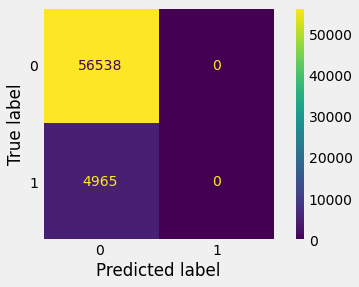


Performance Metrics for DecisionTreeClassifier() :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.0
F1 Score : 0.0
AUROC : 0.63

Best Hyperparam(s) on training set :{'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [ ]:
model = DecisionTreeClassifier()

tuned_parameters = [{'max_depth': range(2, 3), 
                     'min_samples_leaf': [5, 7], 
                     'min_samples_split': [2, 3]}]

df_results_DecisionTree = train_test(model,
                                    tuned_parameters,
                                    X_train_tr,
                                    X_test_tr,
                                    y_train_sample,
                                    y_test)

## Random Forest

Confusion Matrix from predictions for RandomForestClassifier() :


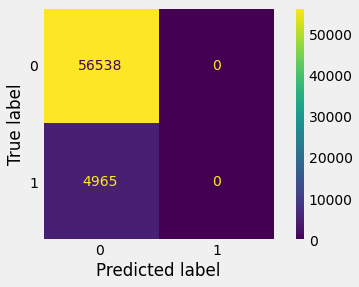


Performance Metrics for RandomForestClassifier() :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.0
F1 Score : 0.0
AUROC : 0.7129

Best Hyperparam(s) on training set :{'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 200}


In [ ]:
model = RandomForestClassifier()

tuned_parameters = [{'n_estimators': [200], 
                     'max_depth': range(10, 50, 5),  #utiliser un pas pour accélerer
                     'min_samples_leaf': [1, 2, 3]}]

df_results_RF = train_test(model,
                          tuned_parameters,
                          X_train_tr,
                          X_test_tr,
                          y_train_sample,
                          y_test)

## LGBM

Confusion Matrix from predictions for LGBMClassifier() :


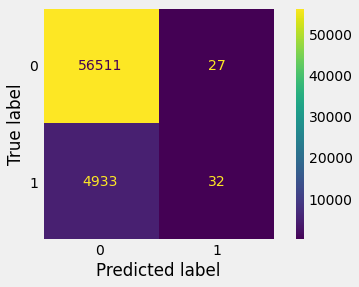


Performance Metrics for LGBMClassifier() :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.0064
F1 Score : 0.0127
AUROC : 0.738

Best Hyperparam(s) on training set :{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': 0.0001}


In [ ]:
model = LGBMClassifier()

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM = train_test(model,
                            tuned_parameters,
                            X_train_tr,
                            X_test_tr,
                            y_train_sample,
                            y_test)

In [ ]:
#Concatenate the results in a signle dataframe
df_results = pd.concat([df_results_baseline, 
                        df_results_Log,
                        df_results_DecisionTree,
                        df_results_RF,
                        df_results_LGBM
                        ])
df_results

,Model,best_params_,roc_auc_score_train,roc_auc_score_test,recall_score_test,f1_score_test
0,DummyClassifier(),{},0.5000,0.5000,0.0000,0.0000
0,LogisticRegression(),{'C': 0.005},0.7438,0.7279,0.0109,0.0212
0,DecisionTreeClassifier(),"{'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}",0.6340,0.6300,0.0000,0.0000
0,RandomForestClassifier(),"{'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 200}",0.7256,0.7129,0.0000,0.0000
0,LGBMClassifier(),"{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7441,0.7380,0.0064,0.0127


# (Managing the imbalance problem)

In our problem, we assume that one false negative is worse than one false positive. 

To be more precise we should compare : 
- the cost of rejecting a crediworthy client and de facto loosing the interest of the loan that would not be concluded
- the cost of accepting an unsolvent client which would not be able to reimburse his debt (it will depend on the type of loan considered : bullet repayment vs by annual instalments) ; 

Let's assume that a default (false negative) is worse than interests earning loss (false positive).  


## Option 1 : Re-sampling


Credits to : https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

First, we need to concatenate X_train_tr and y_train_sample to obtain a sampled dataset on which we can apply Sampling methods to address imbalance problem. 
We name it: `app_train_sample`

In [ ]:
#We us the split sample before encoding and concatenate with test to get the target column
app_train_sample = pd.concat([X_train_sample, y_train_sample], axis=1)

app_train_sample.shape

(24601, 244)

Let's implement a basic example, which uses the `DataFrame.sample` method to get random samples each class:


Class 0: 22615
Class 1: 1986
Proportion: 11.39 : 1


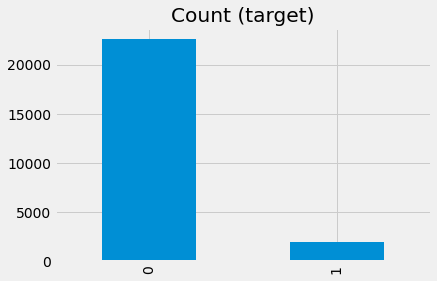

In [ ]:
#Class count
count_class_0, count_class_1 = app_train_sample['TARGET'].value_counts()

#Divide by class
df_class_0 = app_train_sample[app_train_sample['TARGET']==0]
df_class_1 = app_train_sample[app_train_sample['TARGET']==1]

#plot
print('Class 0:', count_class_0)
print('Class 1:', count_class_1)
print('Proportion:', round(count_class_0 / count_class_1, 2), ': 1')

app_train_sample['TARGET'].value_counts().plot(kind='bar', title='Count (target)');

###Random Approach

#### Random-Undersampling


In [ ]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_1, df_class_0_under], axis=0)

Random under-sampling:
1    1986
0    1986
Name: TARGET, dtype: int64


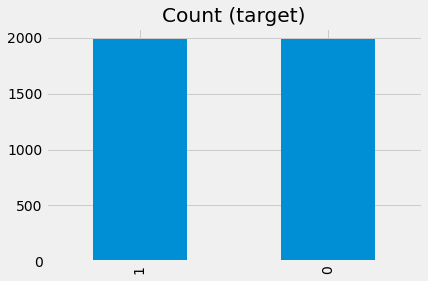

In [ ]:
print(f'Random under-sampling:')
print(df_test_under['TARGET'].value_counts())

df_test_under['TARGET'].value_counts().plot(kind='bar', title='Count (target)');

Let's re-train our so for far best-performing model LGBM on the under-sampled dataframe : 

In [ ]:
X_train_under = df_test_under.drop(['TARGET'], axis=1)
y_train_under = df_test_under['TARGET']


#Transformation Pipeline
pipeline = Pipeline(steps=[
                     ('imputer', imputer),
                     ('scaler', scaler)
])

X_train_under = pipeline.fit_transform(X_train_under)

Confusion Matrix from predictions for LGBMClassifier() :


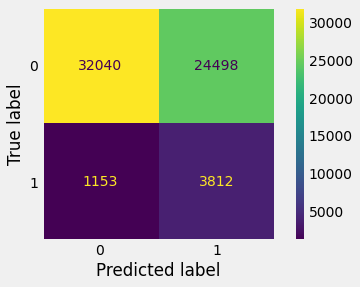


Performance Metrics for LGBMClassifier() :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.7678
F1 Score : 0.2291
AUROC : 0.7305

Best Hyperparam(s) on training set :{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.0001}


In [ ]:
model = LGBMClassifier()

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM_under = train_test(model,
                                  tuned_parameters,
                                  X_train_under,
                                  X_test_tr,
                                  y_train_under,
                                  y_test)

In [ ]:
model = LogisticRegression()

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_under = train_test(model,
                                  tuned_parameters,
                                  X_train_under,
                                  X_test_tr,
                                  y_train_under,
                                  y_test)

In [ ]:
model = RandomForestClassifier()

tuned_parameters = [{'n_estimators': [200], 
                     'max_depth': range(10, 50, 5),  #utiliser un pas pour accélerer
                     'min_samples_leaf': [1, 2, 3]}]

df_results_RF_under = train_test(model,
                                tuned_parameters,
                                X_train_under,
                                X_test_tr,
                                y_train_under,
                                y_test)

#### Random-Oversampling

By oversampling, just duplicating the minority classes could lead the classifier to overfitting.

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print(f'Random over-sampling:')
print(df_over['TARGET'].value_counts())

df_over['TARGET'].value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
X_train_over = df_over.drop(['TARGET'], axis=1)
y_train_over = df_over['TARGET']


#Transformation Pipeline
pipeline = Pipeline(steps=[
                     ('imputer', imputer),
                     ('scaler', scaler)
])

X_train_over = pipeline.fit_transform(X_train_over)

In [ ]:
model = LGBMClassifier()

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM_over = train_test(model,
                                  tuned_parameters,
                                  X_train_over,
                                  X_test_tr,
                                  y_train_over,
                                  y_test)

In [ ]:
model = LogisticRegression()

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_over = train_test(model,
                                tuned_parameters,
                                X_train_over,
                                X_test_tr,
                                y_train_over,
                                y_test)

Confusion Matrix from predictions for RandomForestClassifier() :


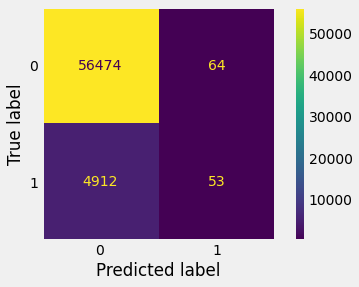


Performance Metrics for RandomForestClassifier() :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.0107
F1 Score : 0.0209
AUROC : 0.7169

Best Hyperparam(s) on training set :{'max_depth': 40, 'min_samples_leaf': 1, 'n_estimators': 200}


In [ ]:
model = RandomForestClassifier()

tuned_parameters = [{'n_estimators': [200], 
                     'max_depth': range(10, 50, 5),  #utiliser un pas pour accélerer
                     'min_samples_leaf': [1, 2, 3]}]

df_results_RF_over = train_test(model,
                                tuned_parameters,
                                X_train_over,
                                X_test_tr,
                                y_train_over,
                                y_test)

### Python imbalanced-learn module

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

In [ ]:
import imblearn

In [ ]:
#2-d plot function
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

Because the dataset has many dimensions (features) and our graphs will be 2D, we will reduce the size of the dataset using Principal Component Analysis (PCA):

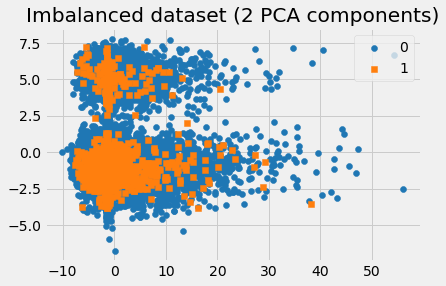

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X = pca.fit_transform(X_train_tr)
y = y_train_sample

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

#### Under-sampling : Tomek links

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/tomek.png?v=2)

In the code below, we'll use `sampling_strategy=majority` to resample the majority class (i.e Under-sampling by removing Tomek’s links which will be majority items)

In [ ]:
from imblearn.under_sampling import TomekLinks
#https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.TomekLinks.html

In [ ]:
print('Original dataset shape %s' % y.value_counts())

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X, y)
print('Resampled dataset shape %s' % y_tl.value_counts())

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

As we have a significant amount of data, plotting in 2d is not very useful. 

In [ ]:
print('Original dataset shape %s' % y_train_sample.value_counts())

tl = TomekLinks(sampling_strategy='majority')
X_train_tl, y_train_tl = tl.fit_resample(X_train_tr, y_train_sample)
print('Resampled dataset shape %s' % y_train_tl.value_counts())

Let's apply Tomek Links undersampling strategy on the full data (before PCA) so we can train and test LGBM on new sampled dataset :  

In [ ]:
model = LGBMClassifier()

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM_tl = train_test(model,
                                tuned_parameters,
                                X_train_tl,
                                X_test_tr,
                                y_train_tl,
                                y_test)

In [ ]:
model = LogisticRegression()

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_tl = train_test(model,
                              tuned_parameters,
                              X_train_tl,
                              X_test_tr,
                              y_train_tl,
                              y_test)

In [ ]:
model = RandomForestClassifier()

tuned_parameters = [{'n_estimators': [200], 
                     'max_depth': range(10, 50, 5),  #utiliser un pas pour accélerer
                     'min_samples_leaf': [1, 2, 3]}]

df_results_RF_tl = train_test(model,
                                tuned_parameters,
                                X_train_tl,
                                X_test_tr,
                                y_train_tl,
                                y_test)

#### Over-sampling: SMOTE
In 2002, a sampling based algorithm called SMOTE (Synthetic Minority Over-Sampling Technique) was introduced that try to address the imbalanced class problem. It is one of the most adopted approaches due to its simplicity and effectiveness. It is a combination of oversampling and undersampling, but the oversampling approach is not by replicating minority class but constructing new minority class data instance via an algorithm.

In traditional oversampling, minority class is replicated exactly. In SMOTE, new minority instances are constructed in this way:

![image](http://www.chioka.in/wp-content/uploads/2013/08/SMOTE.png)

 ![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

The intuition behind the construction algorithm is that oversampling causes overfit because of repeated instances causes the decision boundary to tighten. Instead, we will create “similar” examples instead. To the machine learning algorithm, these new constructed instances are not exact copies and thus softens the decision boundary as a result. 

In [ ]:
from imblearn.over_sampling import SMOTE
#https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [ ]:
print('Original dataset shape %s' % y_train_sample.value_counts())

smote = SMOTE(sampling_strategy='minority') #resample only the minority class;
X_sm, y_sm = smote.fit_resample(X_train_tr, y_train_sample)
print('Resampled dataset shape %s' % y_sm.value_counts())

In [ ]:
#training our model on the re-sampled SMOTE data
model = LGBMClassifier()

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM_sm = train_test(model,
                                tuned_parameters,
                                X_sm,
                                X_test_tr,
                                y_sm,
                                y_test)

In [ ]:
model = LogisticRegression()

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_sm = train_test(model,
                                tuned_parameters,
                                X_sm,
                                X_test_tr,
                                y_sm,
                                y_test)

In [ ]:
model = RandomForestClassifier()

tuned_parameters = [{'n_estimators': [200], 
                     'max_depth': range(10, 50, 10),  #utiliser un pas pour accélerer
                     'min_samples_leaf': [1, 2, 3]}]

df_results_RF_sm = train_test(model,
                              tuned_parameters,
                              X_sm,
                              X_test_tr,
                              y_sm,
                              y_test)

Our model performs poorly due as almost every items are identified as postive (unsolvent client). 

(see later) Deeper analysis : look into more recent literature regarding RUSBoost, SMOTEBagging and Underbagging, which are all regarded as more promising approaches since SMOTE.

#### Combined-sampling : SMOTETomek

In [ ]:
from imblearn.combine import SMOTETomek
#https://imbalanced-learn.org/dev/references/generated/imblearn.combine.SMOTETomek.html

In [ ]:
print('Original dataset shape %s' % y_train_sample.value_counts())

smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_resample(X_train_tr, y_train_sample)
print('Resampled dataset shape %s' % y_sm.value_counts())

In [ ]:
#training our model on the re-sampled SMOTE data
model = LGBMClassifier()

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM_smt = train_test(model,
                                tuned_parameters,
                                X_smt,
                                X_test_tr,
                                y_smt,
                                y_test)

In [ ]:
model = LogisticRegression()

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_smt = train_test(model,
                              tuned_parameters,
                              X_smt,
                              X_test_tr,
                              y_smt,
                              y_test)

In [ ]:
model = RandomForestClassifier()

tuned_parameters = [{'n_estimators': [200], 
                     'max_depth': range(10, 50, 10),  #utiliser un pas pour accélerer
                     'min_samples_leaf': [1, 2, 3]}]

df_results_RF_smt = train_test(model,
                              tuned_parameters,
                              X_smt,
                              X_test_tr,
                              y_smt,
                              y_test)

## Option 2 : Hyper-parameter : class_weights

Credits to : https://www.kaggle.com/eikedehling/exploring-class-imbalance-resampling-and-weights

#### Automatic tuning: `balanced`

Another possibility is to use the model hyperparameter `class_weights` to tell the model there is class-imbalance and to put weights on errors proportional to the class imbalance.

The `balanced` mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`




In [ ]:
model = LGBMClassifier(class_weight = 'balanced') 

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM_bal = train_test(model,
                                tuned_parameters,
                                X_train_tr,
                                X_test_tr,
                                y_train_sample,
                                y_test)

The result obtained is not very different compared to LGBM without any hyper-parameter `class_weights set`

In [ ]:
model = LogisticRegression(class_weight = 'balanced')

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_bal = train_test(model,
                                tuned_parameters,
                                X_train_tr,
                                X_test_tr,
                                y_train_sample,
                                y_test)

In [ ]:
model = RandomForestClassifier(class_weight = 'balanced')

tuned_parameters = [{'n_estimators': [200], 
                     'max_depth': range(10, 50, 10),  #utiliser un pas pour accélerer
                     'min_samples_leaf': [1, 2, 3]}]

df_results_RF_bal = train_test(model,
                              tuned_parameters,
                              X_sm,
                              X_test_tr,
                              y_sm,
                              y_test)

#### Manual tuning

Credits : https://www.kaggle.com/eikedehling/exploring-class-imbalance-resampling-and-weights

We can also tune the class weights manually to find a better trade-off between false positives, false negatives and detected solvency issues. The F1 score is a metric that attempts to take that tradeoff.

In [ ]:
weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LGBMClassifier(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)
grid_result = gsc.fit(X_train_tr, y_train_sample)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

Now we create a model with the optimum parameters we discovered above and plot results again. This version results in a more balanced tradeoff between false positives, false negatives and finding solvency issues.



In [ ]:
model = LGBMClassifier(**grid_result.best_params_)
model = LGBMClassifier()


tuned_parameters = [{'max_depth': [4], 
                    'learning_rate': [0.01], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}
                     ]

df_results_LGBM_man = train_test(model,
                                tuned_parameters,
                                X_train_tr,
                                X_test_tr,
                                y_train_sample,
                                y_test)

Logistic Regression

In [ ]:
weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)
grid_result = gsc.fit(X_train_tr, y_train_sample)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [ ]:
model = LogisticRegression(**grid_result.best_params_)
#** to unpack the dictionary 
#https://docs.python.org/3/reference/expressions.html#calls
#https://www.stashofcode.fr/operateurs-etoile-en-python/#:~:text=Les%20op%C3%A9rateurs%20*%20et%20**%20peuvent,arguments%20dont%20il%20est%20question.

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_man = train_test(model,
                                tuned_parameters,
                                X_train_tr,
                                X_test_tr,
                                y_train_sample,
                                y_test)

Random Forest

In [ ]:
weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)
grid_result = gsc.fit(X_train_tr, y_train_sample)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [ ]:
model = RandomForestClassifier(**grid_result.best_params_)

tuned_parameters = [{'n_estimators': [200], 
                     'max_depth': range(10, 50, 10),  #utiliser un pas pour accélerer
                     'min_samples_leaf': [1, 2, 3]}]

df_results_RF_man = train_test(model,
                                tuned_parameters,
                                X_train_tr,
                                X_test_tr,
                                y_train_sample,
                                y_test)

# (Selecting the best models)

Let's concatenate the results in a dataframe.

In [ ]:
df_results['Improvements'] = 'n.a'

df_results_Log_under['Improvements'] = 'UnderSampling'
df_results_RF_under['Improvements'] = 'UnderSampling'
df_results_LGBM_under['Improvements'] = 'UnderSampling'

df_results_Log_over['Improvements'] = 'OverSampling'
df_results_LGBM_over['Improvements'] = 'OverSampling'
df_results_RF_over['Improvements'] = 'OverSampling'

df_results_Log_tl['Improvements'] = 'TomekLinks'
df_results_LGBM_tl['Improvements'] = 'TomekLinks'
df_results_RF_tl['Improvements'] = 'TomekLinks'

df_results_Log_sm['Improvements'] = 'SMOTE'
df_results_LGBM_sm['Improvements'] = 'SMOTE'
df_results_RF_sm['Improvements'] = 'SMOTE'

df_results_Log_smt['Improvements'] = 'SMOTETomek'
df_results_LGBM_smt['Improvements'] = 'SMOTETomek'
df_results_RF_smt['Improvements'] = 'SMOTETomek'

df_results_Log_bal['Improvements'] = 'Balanced_class_weight'
df_results_LGBM_bal['Improvements'] = 'Balanced_class_weight'
df_results_RF_bal['Improvements'] = 'Balanced_class_weight'

df_results_Log_man['Improvements'] = 'Manual_class_weight'
df_results_LGBM_man['Improvements'] = 'Manual_class_weight'
df_results_RF_man['Improvements'] = 'Manual_class_weight'


In [ ]:
df_results_improvements = pd.concat([df_results 
                                    ,df_results_Log_under
                                    ,df_results_RF_under
                                    ,df_results_LGBM_under
                                    ,df_results_Log_over
                                    ,df_results_LGBM_over
                                    ,df_results_RF_over
                                    ,df_results_Log_tl
                                    ,df_results_LGBM_tl
                                    ,df_results_RF_tl
                                    ,df_results_Log_sm
                                    ,df_results_LGBM_sm
                                    ,df_results_RF_sm
                                    ,df_results_Log_smt
                                    ,df_results_LGBM_smt
                                    ,df_results_RF_smt
                                    ,df_results_Log_bal
                                    ,df_results_LGBM_bal
                                    ,df_results_RF_bal
                                    ,df_results_Log_man
                                    ,df_results_LGBM_man
                                    ,df_results_RF_man
                        ])
df_results_improvements

,Model,best_params_,roc_auc_score_train,roc_auc_score_test,recall_score_test,f1_score_test,Improvements
0,DummyClassifier(),{},0.5000,0.5000,0.0000,0.0000,n.a
0,LogisticRegression(),{'C': 0.005},0.7438,0.7279,0.0109,0.0212,n.a
0,DecisionTreeClassifier(),"{'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}",0.6340,0.6300,0.0000,0.0000,n.a
0,RandomForestClassifier(),"{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}",0.7255,0.7168,0.0000,0.0000,n.a
0,LGBMClassifier(),"{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7441,0.7380,0.0064,0.0127,n.a
0,LogisticRegression(),{'C': 0.005},0.7436,0.7252,0.7760,0.2219,UnderSampling
0,RandomForestClassifier(),"{'max_depth': 45, 'min_samples_leaf': 3, 'n_estimators': 200}",0.7385,0.7234,0.7414,0.2310,UnderSampling
0,LGBMClassifier(),"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7433,0.7306,0.7698,0.2277,UnderSampling
0,LogisticRegression(),{'C': 0.01},0.7675,0.7271,0.7774,0.2232,OverSampling
0,LGBMClassifier(),"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.9480,0.6953,0.4731,0.2424,OverSampling


Best results are obtained for the followings:

- Balanced Class_weight
  - Logistic Regression
  - LGBM


We prefer balanced way of addressing the imbalanced problem rather than undersampling as the recall level of the latter is too high. In other words the True Positive rate is quite high due to a high false positive items. As we want to successfully identify postive items while limiting the number of error we would rather use the `class_weight = balanced` approach. 


# Feature engineering

## Feature creation

From `HomeCredi_columns_description:`
- `AMT_INCOME_TOTAL` = Income of the client
- `AMT_CREDIT` = Credit amount of the loan
- `AMT_ANNUITY` = Loan annuity
- `AMT_GOODS_PRICE` = For consumer loans it is the price of the goods for which the loan is given

Let's engineered several features based on our understanding of the data : 

- Weight of the annuity in the total income: ` AMT_INCOME_TOTAL / AMT_ANNUITY`

- Duration of the loan: `loan_duration: AMT_CREDIT / AMT_ANNUITY`

- Percentage of loan needed to finance the good:`credit_goods_price_ratio= AMT_CREDIT / AMT_GOODS_PRICE`

- Amount of good financed without loan:`credit_downpayment= AMT_GOOD_PRICE - AMT_CREDIT`

- Age of the contractor: `AGE_INT = int(DAYS_BIRTH / 365)`

In [ ]:
app_train['annuity_income_ratio'] = app_train['AMT_INCOME_TOTAL'] / app_train['AMT_ANNUITY'] 
app_train['credit_annuity_ratio'] = app_train['AMT_CREDIT'] / app_train['AMT_ANNUITY']
app_train['credit_goods_price_ratio'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE']
app_train['credit_downpayment'] = app_train['AMT_GOODS_PRICE'] - app_train['AMT_CREDIT']

app_train['AGE_INT'] = (app_train['DAYS_BIRTH'] / 365).astype(int)

As we have done modifications on the `app_train` dataset, we need to split and sample the training set again to include de features created. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(app_train.drop(['TARGET'], axis=1), #x
                                                    app_train['TARGET'], #y
                                                    test_size=0.2,
                                                    stratify=app_train['TARGET'], #stratified sample
                                                    random_state=123)

X_unused, X_train_sample, y_train_unused, y_train_sample = train_test_split(X_train, 
                                                                            y_train, #y
                                                                            test_size=0.1,
                                                                            stratify=y_train, #stratified sample
                                                                            random_state=123)

print(f'Size of Stratified sample :{X_train_sample.shape}')
print(f'As a % of training set :{(X_train_sample.shape[0] / X_train.shape[0]) * 100}')

#encoding already done 

#missing values
imputer = SimpleImputer(strategy="median")

#standardisation
scaler = StandardScaler()

#Transformation Pipeline
pipeline = Pipeline(steps=[
                     ('imputer', imputer),
                     ('scaler', scaler)
])

X_train_tr = pipeline.fit_transform(X_train_sample)
X_test_tr = pipeline.transform(X_test)

Size of Stratified sample :(24601, 248)
As a % of training set :10.000081298169166


###Measure performance improvement

Let's retrain our best model with these new features. 

Confusion Matrix from predictions for LGBMClassifier(class_weight='balanced') :


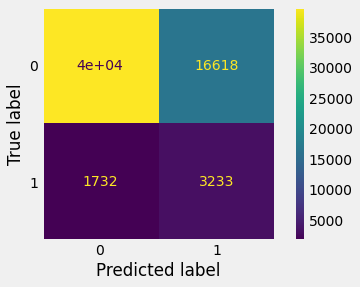


Performance Metrics for LGBMClassifier(class_weight='balanced') :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.6512
F1 Score : 0.2606
AUROC : 0.7404

Best Hyperparam(s) on training set :{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.0001}


In [ ]:
model = LGBMClassifier(class_weight = 'balanced') 

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM_bal_fe = train_test(model,
                                tuned_parameters,
                                X_train_tr,
                                X_test_tr,
                                y_train_sample,
                                y_test)

Confusion Matrix from predictions for LogisticRegression(class_weight='balanced') :


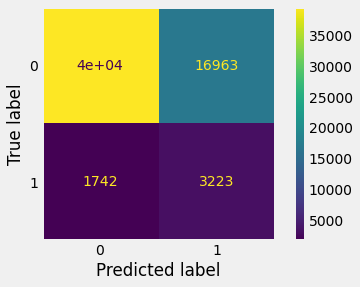


Performance Metrics for LogisticRegression(class_weight='balanced') :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.6491
F1 Score : 0.2563
AUROC : 0.732

Best Hyperparam(s) on training set :{'C': 0.001}


In [ ]:
model = LogisticRegression(class_weight = 'balanced')

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_bal_fe = train_test(model,
                                tuned_parameters,
                                X_train_tr,
                                X_test_tr,
                                y_train_sample,
                                y_test)

Let's see the results : 

In [ ]:
df_results_LGBM_bal_fe['Improvements'] = 'Feature_eng'
df_results_Log_bal_fe['Improvements'] = 'Feature_eng'

In [ ]:
df_results_features = pd.concat([
                                df_results_baseline 
                                ,df_results_Log
                                ,df_results_LGBM
                                ,df_results_Log_bal
                                ,df_results_LGBM_bal
                                ,df_results_Log_bal_fe
                                ,df_results_LGBM_bal_fe
])
df_results_features

,Model,best_params_,roc_auc_score_train,roc_auc_score_test,recall_score_test,f1_score_test,Improvements
0,DummyClassifier(),{},0.5000,0.5000,0.0000,0.0000,NaN
0,LogisticRegression(),{'C': 0.005},0.7438,0.7279,0.0109,0.0212,NaN
0,LGBMClassifier(),"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.7441,0.7380,0.0064,0.0127,NaN
0,LogisticRegression(class_weight='balanced'),{'C': 0.001},0.7426,0.7286,0.6473,0.2547,NaN
0,LGBMClassifier(class_weight='balanced'),"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.7414,0.7360,0.6352,0.2617,NaN
0,LogisticRegression(class_weight='balanced'),{'C': 0.001},0.7462,0.7320,0.6491,0.2563,Feature_eng
0,LGBMClassifier(class_weight='balanced'),"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.7467,0.7404,0.6512,0.2606,Feature_eng


We can see a slight improvement on the performance metrics as the AUROC on test set and Recall have improved. 

## Feature selection

Credits : https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection

https://www.kaggle.com/sz8416/6-ways-for-feature-selection

We one hot encoded the full `app_train` dataset before splitting it. The number of features currently equals to **249**. 

In [ ]:
app_train.shape

(307511, 249)

The number of feature being big might seem like a good thing, and they can be if they help our model learn. However, irrelevant features, highly correlated features, and missing values can prevent the model from learning and decrease generalization performance on the testing data. Therefore, we perform feature selection to keep only the most useful variables.

We will start feature selection by focusing on collinear variables.


### (Remove Collinear Variables)

Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. Clearly, these are three things we want to increase, so removing collinear variables is a useful step. We will establish an admittedly arbitrary threshold for removing collinear variables, and then remove one out of any pair of variables that is above that threshold.

The code below identifies the highly correlated variables based on the absolute magnitude of the Pearson correlation coefficient being greater than 0.9.

In [ ]:
#Threshold for removing correlated variables
threshold_col = 0.9

#absolute value correlation matrix
corr_matrix = app_train.corr().abs()
corr_matrix.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,annuity_income_ratio,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT
SK_ID_CURR,1.000000,0.002108,0.001654,0.001216,0.000703,0.001129,0.001820,0.000343,0.000433,0.000232,...,0.001281,0.000270,0.000510,0.002549,0.001368,0.001999,9.266672e-07,0.001060,0.000052,0.001467
TARGET,0.002108,1.000000,0.030896,0.021851,0.006148,0.019187,0.003982,0.030369,0.012817,0.039645,...,0.012657,0.007946,0.042201,0.004829,0.045987,0.003947,3.210152e-02,0.069427,0.034254,0.078234
NAME_CONTRACT_TYPE,0.001654,0.030896,1.000000,0.004022,0.067177,0.029998,0.003531,0.221648,0.241544,0.185850,...,0.015098,0.000040,0.027372,0.000339,0.054967,0.149549,6.743310e-02,0.322348,0.284861,0.086288
FLAG_OWN_CAR,0.001216,0.021851,0.004022,1.000000,0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,...,0.025584,0.009212,0.034754,0.007584,0.154778,0.029903,1.803238e-02,0.036488,0.030577,0.129867
FLAG_OWN_REALTY,0.000703,0.006148,0.067177,0.002817,1.000000,0.002366,0.002934,0.039270,0.005225,0.045537,...,0.017445,0.014577,0.022013,0.008535,0.070107,0.011030,7.447506e-02,0.029953,0.015165,0.119164


In [ ]:
#upper triangle of correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,annuity_income_ratio,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT
SK_ID_CURR,NaN,0.002108,0.001654,0.001216,0.000703,0.001129,0.001820,0.000343,0.000433,0.000232,...,0.001281,0.000270,0.000510,0.002549,0.001368,0.001999,9.266672e-07,0.001060,0.000052,0.001467
TARGET,NaN,NaN,0.030896,0.021851,0.006148,0.019187,0.003982,0.030369,0.012817,0.039645,...,0.012657,0.007946,0.042201,0.004829,0.045987,0.003947,3.210152e-02,0.069427,0.034254,0.078234
NAME_CONTRACT_TYPE,NaN,NaN,NaN,0.004022,0.067177,0.029998,0.003531,0.221648,0.241544,0.185850,...,0.015098,0.000040,0.027372,0.000339,0.054967,0.149549,6.743310e-02,0.322348,0.284861,0.086288
FLAG_OWN_CAR,NaN,NaN,NaN,NaN,0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,...,0.025584,0.009212,0.034754,0.007584,0.154778,0.029903,1.803238e-02,0.036488,0.030577,0.129867
FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,NaN,0.002366,0.002934,0.039270,0.005225,0.045537,...,0.017445,0.014577,0.022013,0.008535,0.070107,0.011030,7.447506e-02,0.029953,0.015165,0.119164


In [ ]:
to_drop = [col for col in upper.columns if any(upper[col] > threshold_col)]

print(f'There are {len(to_drop)} columns to remove')
print(sorted(to_drop))

There are 40 columns to remove
['AGE_INT', 'AMT_GOODS_PRICE', 'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'CODE_GENDER_M', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'DAYS_EMPLOYED_ANOM', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE_No', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'NAME_INCOME_TYPE_Pensioner', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'ORGANIZATION_TYPE_XNA', 'REGION_RATING_CLIENT_W_CITY', 'TOTALAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE']


In [ ]:
corr_matrix['AGE_INT'].sort_values()

NAME_INCOME_TYPE_Businessman    0.000031
LIVINGAREA_MODE                 0.000037
LIVINGAREA_MEDI                 0.000085
FLAG_DOCUMENT_10                0.000111
FLAG_DOCUMENT_12                0.000200
                                  ...   
ORGANIZATION_TYPE_XNA           0.619887
DAYS_EMPLOYED_ANOM              0.619887
NAME_INCOME_TYPE_Pensioner      0.620011
DAYS_BIRTH                      0.999711
AGE_INT                         1.000000
Name: AGE_INT, Length: 249, dtype: float64

`AGE_INT` is more readable than `DAYS_BIRTH` : this is the reason why we will prefer to drop the latter. 

In [ ]:
#drop DAYS_BIRTH rather than AGE_INT
to_drop.remove('AGE_INT')
to_drop.append('DAYS_BIRTH')
to_drop.sort()
print(to_drop)

['AMT_GOODS_PRICE', 'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'CODE_GENDER_M', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'DAYS_BIRTH', 'DAYS_EMPLOYED_ANOM', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE_No', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'NAME_INCOME_TYPE_Pensioner', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'ORGANIZATION_TYPE_XNA', 'REGION_RATING_CLIENT_W_CITY', 'TOTALAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE']


In [ ]:
corr_matrix['AMT_GOODS_PRICE'].sort_values()

WEEKDAY_APPR_PROCESS_START_SUNDAY    0.000080
ORGANIZATION_TYPE_Mobile             0.000154
FLAG_DOCUMENT_7                      0.000202
SK_ID_CURR                           0.000232
ORGANIZATION_TYPE_Emergency          0.000314
                                       ...   
credit_annuity_ratio                 0.632199
AMT_ANNUITY                          0.775109
AMT_CREDIT                           0.986968
AMT_GOODS_PRICE                      1.000000
NAME_FAMILY_STATUS_Unknown                NaN
Name: AMT_GOODS_PRICE, Length: 249, dtype: float64

Studying colinearity lead us to identify `AMT_GOODS_PRICE` as being redundant with `AMT_CREDIT`. In another hand our understanding of the data make us think the contrary. 

By caution, we will choose not to remove collinear variables.

In [ ]:
#keep AMT_GOODS_PRICE
to_drop.remove('AMT_GOODS_PRICE')
to_drop.sort()
print(to_drop)

['APARTMENTS_MEDI', 'APARTMENTS_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'CODE_GENDER_M', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'DAYS_BIRTH', 'DAYS_EMPLOYED_ANOM', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE_No', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'NAME_INCOME_TYPE_Pensioner', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'ORGANIZATION_TYPE_XNA', 'REGION_RATING_CLIENT_W_CITY', 'TOTALAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE']


### RFE
Recursive feature elimination
https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [ ]:
columns_list = X_train_sample.columns.to_list()

In [ ]:
def train_RFECV(model, x_train, y_train):
  
  #https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
  
  min_features_to_select = 1

  rfecv = RFECV(
                estimator=model,
                step=10,
                cv=StratifiedKFold(2),
                scoring="roc_auc",
                min_features_to_select=min_features_to_select,
                ) 
  rfecv.fit(x_train, y_train)
  
  print("Optimal number of features : %d" % rfecv.n_features_)

  # Plot number of features VS. cross-validation scores
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (AUROC)")
  plt.plot(
      range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
      rfecv.grid_scores_,)
  plt.show()

  #Get select features
  rfe_support = rfecv.get_support() #get integer index of the features selected

  columns_importants = [columns_list[i] for i, is_support in enumerate(rfe_support) if is_support] 
  print("Optimal number of features : %d" % rfecv.n_features_)

  return columns_importants

Optimal number of features : 78


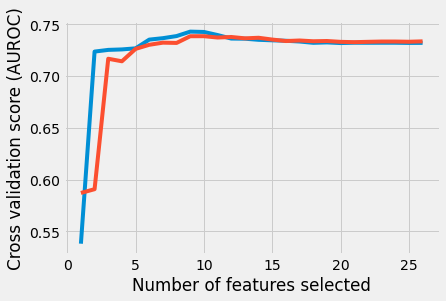

Optimal number of features : 78


In [ ]:
model = LogisticRegression(class_weight = 'balanced')

columns_importants_RegLog = train_RFECV(model,
                                        X_train_tr,
                                        y_train_sample
                                        )

At this point we would like to compare the optimal features identified by Recursive feature elimination with cross-validation (RFECV) with colinear variables:


In [ ]:
#optimal features
columns_importants_RegLog

#colinear variables
to_drop

#intersection of the two
[item for item in columns_importants_RegLog if item in to_drop]

['DAYS_BIRTH',
 'REGION_RATING_CLIENT_W_CITY',
 'LIVINGAREA_AVG',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'CODE_GENDER_M',
 'NAME_INCOME_TYPE_Pensioner',
 'EMERGENCYSTATE_MODE_No']

Optimal number of features : 108


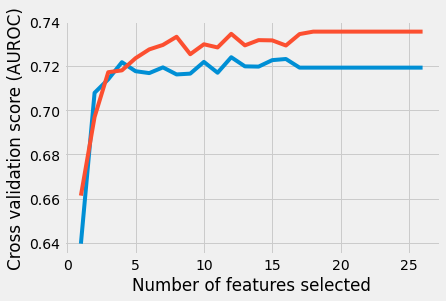

Optimal number of features : 108


In [ ]:
model = LGBMClassifier(class_weight = 'balanced')

columns_importants_LGBM = train_RFECV(model,
                                        X_train_tr,
                                        y_train_sample
                                        )

In [ ]:
diff = [col for col in columns_importants_LGBM if col not in columns_importants_RegLog]
print(f'{len(diff)} columns selected by RFE fitted on LGBM and not selected when fitted on RegLog')
print(diff)

50 columns selected by RFE fitted on LGBM and not selected when fitted on RegLog
['SK_ID_CURR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY', 'LIVINGAPARTMENTS_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ENTRANCES_MODE', 'LIVINGAPARTMENTS_MODE', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER_F', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Working', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_House / apartment', 'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Low-skill Laborers', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WE

As `RFECV` identifies less useless features when fitted on `LGBMClassifier` compared to `LogisticRegression` we will keep the greatest number of features of the two approaches in order to prevent information loss.  

In [ ]:
col_to_drop_RFECV = [col for col in columns_list if col not in columns_importants_LGBM]

#Drop columns
X_train_tr_RFECV = pd.DataFrame(data=pipeline.fit_transform(X_train_sample), columns=columns_list).drop(col_to_drop_RFECV, axis=1)
X_test_tr_RFECV = pd.DataFrame(data=pipeline.fit_transform(X_test), columns=columns_list).drop(col_to_drop_RFECV, axis=1)

#### Measure performance improvement

To appreciate the impact of the feature elimination performed using `RFECV` let's add an execution time metric to our `train_test` function. We will name the amended function : `train_test_fe`  


In [ ]:
def train_test_fe (model, tuned_parameters, x_train, x_test, y_train, y_test):
  
  #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
  #https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308256-evaluez-un-algorithme-de-classification-qui-retourne-des-valeurs-binaires

  clf = GridSearchCV(model, 
                    param_grid=tuned_parameters, 
                    scoring='roc_auc', 
                    refit='roc_auc',
                    cv=5,
                    return_train_score=True
                    )
  clf.fit(x_train, y_train)
  roc_auc_score_train = round(clf.best_score_,4)
  
  y_pred_proba = clf.best_estimator_.predict_proba(x_test) 
  y_pred_proba = y_pred_proba[:, 1]
  threshold = 0.5
  y_pred = y_pred_proba > threshold
  y_pred = y_pred.astype(int)

  #confusion matrix from predictions
  print(f'Confusion Matrix from predictions for {model} :')
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.grid(False)
  plt.show()
  print()

  #performance metrics on test set
  recall_score = round(sklearn.metrics.recall_score(y_test, y_pred),4)
  f1_score = round(sklearn.metrics.f1_score(y_test, y_pred),4)
  roc_auc_score = round(sklearn.metrics.roc_auc_score(y_test, y_pred_proba),4)

  #execution time
  mean_fit_time = clf.cv_results_['mean_fit_time']
  mean_score_time = clf.cv_results_['mean_score_time']
  n_splits = clf.n_splits_ #number of splits of training data
  n_iter = pd.DataFrame(clf.cv_results_).shape[0] #Iterations it takes per split for the solver to converge 
  execution_time = round(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter, 0)

  #return (i) perf metrics (ii) best hyperparams
  print(f'Performance Metrics for {model} :')
  print(f'Recall/sensitivity [true positive rate = TP / (TP + FN)]: {recall_score}')
  print(f'F1 Score : {f1_score}')
  print(f'AUROC : {roc_auc_score}')
  print(f'Execution time (sec): {execution_time}')
  print()
  
  print(f'Best Hyperparam(s) on training set :{clf.best_params_}')

  # store results in a dataframe
  df_results = pd.DataFrame(columns=['Model',
                                     'best_params_', 
                                     'roc_auc_score_train', 
                                     'roc_auc_score_test', 
                                     'recall_score_test',
                                     'f1_score_test',
                                     'execution_time (sec)'
                                     ])

  data = {'Model': [model], 
          'best_params_' : [clf.best_params_], 
          'roc_auc_score_train' : [roc_auc_score_train],
          'roc_auc_score_test' : [roc_auc_score],
          'recall_score_test' : [recall_score], 
          'f1_score_test': [f1_score], 
          'execution_time (sec)': [execution_time]
          }

  results = pd.DataFrame.from_dict(data)

  df_results = df_results.append(results)

  return df_results

Let's retrain ou best models with selected features:

Confusion Matrix from predictions for LGBMClassifier(class_weight='balanced') :


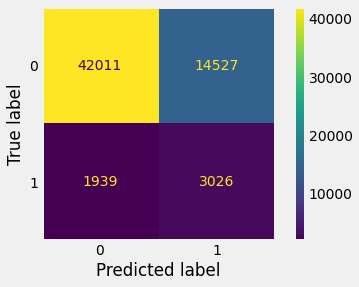


Performance Metrics for LGBMClassifier(class_weight='balanced') :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.6095
F1 Score : 0.2688
AUROC : 0.7391
Execution time (sec): 296.0

Best Hyperparam(s) on training set :{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.0001}


In [ ]:
model = LGBMClassifier(class_weight = 'balanced') 

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM_bal_fe_RFECV = train_test_fe(model,
                                tuned_parameters,
                                X_train_tr_RFECV,
                                X_test_tr_RFECV,
                                y_train_sample,
                                y_test)

Confusion Matrix from predictions for LGBMClassifier(class_weight='balanced') :


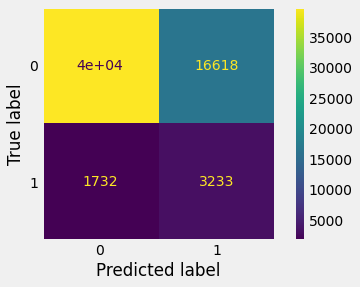


Performance Metrics for LGBMClassifier(class_weight='balanced') :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.6512
F1 Score : 0.2606
AUROC : 0.7404
Execution time (sec): 397.0

Best Hyperparam(s) on training set :{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.0001}


In [ ]:
model = LGBMClassifier(class_weight = 'balanced') 

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM_bal_fe = train_test_fe(model,
                                tuned_parameters,
                                X_train_tr,
                                X_test_tr,
                                y_train_sample,
                                y_test)

Confusion Matrix from predictions for LogisticRegression(class_weight='balanced') :


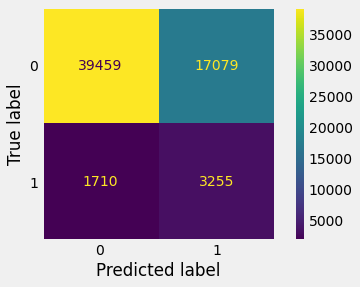


Performance Metrics for LogisticRegression(class_weight='balanced') :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.6556
F1 Score : 0.2573
AUROC : 0.7353
Execution time (sec): 7.0

Best Hyperparam(s) on training set :{'C': 0.001}


In [ ]:
model = LogisticRegression(class_weight = 'balanced')

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_bal_fe_RFECV = train_test_fe(model,
                                tuned_parameters,
                                X_train_tr_RFECV,
                                X_test_tr_RFECV,
                                y_train_sample,
                                y_test)

Confusion Matrix from predictions for LogisticRegression(class_weight='balanced') :


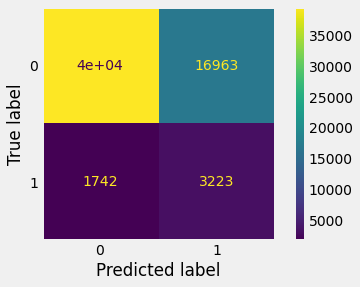


Performance Metrics for LogisticRegression(class_weight='balanced') :
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.6491
F1 Score : 0.2563
AUROC : 0.732
Execution time (sec): 9.0

Best Hyperparam(s) on training set :{'C': 0.001}


In [ ]:
model = LogisticRegression(class_weight = 'balanced')

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_bal_fe_ = train_test_fe(model,
                                tuned_parameters,
                                X_train_tr,
                                X_test_tr,
                                y_train_sample,
                                y_test)

In [ ]:
df_results_LGBM_bal_fe['Improvements'] = 'Feature_eng'
df_results_Log_bal_fe_['Improvements'] = 'Feature_eng'
df_results_LGBM_bal_fe_RFECV['Improvements'] = 'Feature_eng + RFECV'
df_results_Log_bal_fe_RFECV['Improvements'] = 'Feature_eng + RFECV'

df_results_features = pd.concat([
                                df_results_LGBM_bal_fe
                                ,df_results_LGBM_bal_fe_RFECV 
                                ,df_results_Log_bal_fe_
                                ,df_results_Log_bal_fe_RFECV
])
df_results_features

,Model,best_params_,roc_auc_score_train,roc_auc_score_test,recall_score_test,f1_score_test,execution_time (sec),Improvements
0,LGBMClassifier(class_weight='balanced'),"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7467,0.7404,0.6512,0.2606,397.0,Feature_eng
0,LGBMClassifier(class_weight='balanced'),"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7466,0.7391,0.6095,0.2688,296.0,Feature_eng + RFECV
0,LogisticRegression(class_weight='balanced'),{'C': 0.001},0.7462,0.7320,0.6491,0.2563,9.0,Feature_eng
0,LogisticRegression(class_weight='balanced'),{'C': 0.001},0.7517,0.7353,0.6556,0.2573,7.0,Feature_eng + RFECV


By droppping 90 variables we noticed a slight decrease of the AUROC on the testing set of LGBM. 
On the other hand, Logistic Regression slightly improved on these metrics while improving its execution time. 
We will therefore use this feature selection approach. 

# (Finding a new Performance metric)

The goal of our project is to be able to precisely predict the capacity of a client to reimburse his loan. In another words, to prevent the lender (the bank) from untrustworthy clients. 

If we translate this business problem to our machine learning process, we need to adapt the performance metrics that we try to maximise in order to fit the bank objectives. 


The confusion matrix can be translated in business terms as (from the Bank perspective):
- TP: Unsolvent clients correctly identified 
  - Loss = 0, Earn = 0 
- FP: Clients identified as unsolvent that are not 
  - Loss = Interest of the loan (not contracted)
- TN: Solvent clients correctly identified
  - Earn = Interest of the loan
- FN: Unsolvent clients identify as solvent 
  - Loss = Principal of the loan + interests not yet received

False Negative clearly appears to be the worst case scenario that we shall prevent. 

As recall and precision are defined as follows:
- recall: % of relevant items identified
- precision: % of items identified that are relevant

**We therefore need to prefer recall rather than precision.** 

## Fbeta_score

The [`fbeta_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) is a metric similar to `f-1 score` which adds an hyperparameter `beta`.

The beta parameter determines the weight of recall in the combined score. 
- beta < 1 lends more weight to precision
- while beta > 1 favors recall 

(beta -> 0 considers only precision, beta -> +inf only recall).

In order to best fit the business purpose of the model, we will prefer performance 

Let's modify our `train_test` function to add this performance metric. The strategy to evaluate the performance of the cross-validated model on the test set, defined by `scoring` parameter should be modified to `fbetascore` 

In [ ]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)
type(ftwo_scorer)

sklearn.metrics._scorer._PredictScorer

In [ ]:
def train_test_f2 (model, beta, tuned_parameters, x_train, x_test, y_train, y_test, beta_search=None):
  
  #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
  #https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308256-evaluez-un-algorithme-de-classification-qui-retourne-des-valeurs-binaires

  scorer = make_scorer(fbeta_score, beta=beta)

  clf = GridSearchCV(model, 
                    param_grid=tuned_parameters, 
                    scoring=scorer, 
                    refit=True,
                    cv=5,
                    return_train_score=True
                    )
  clf.fit(x_train, y_train)
  
  y_pred_train_proba = clf.best_estimator_.predict_proba(x_train) 
  y_pred_train_proba = y_pred_train_proba[:, 1]

  y_pred_proba = clf.best_estimator_.predict_proba(x_test) 
  y_pred_proba = y_pred_proba[:, 1]
  threshold = 0.5
  y_pred = y_pred_proba > threshold
  y_pred = y_pred.astype(int)

  #confusion matrix from predictions
  print(f'Confusion Matrix from predictions for {model} :')
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.grid(False)
  plt.show()
  print()

  #performance metrics on test set
  recall_score = round(sklearn.metrics.recall_score(y_test, y_pred),4)
  f1_score = round(sklearn.metrics.f1_score(y_test, y_pred),4)
  roc_auc_score_train = round(sklearn.metrics.roc_auc_score(y_train, y_pred_train_proba),4)
  roc_auc_score = round(sklearn.metrics.roc_auc_score(y_test, y_pred_proba),4)
  fbeta_score_ = round(sklearn.metrics.fbeta_score(y_test, y_pred, beta=beta),4)

  #execution time
  mean_fit_time = clf.cv_results_['mean_fit_time']
  mean_score_time = clf.cv_results_['mean_score_time']
  n_splits = clf.n_splits_ #number of splits of training data
  n_iter = pd.DataFrame(clf.cv_results_).shape[0] #Iterations it takes per split for the solver to converge 
  execution_time = round(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter, 0)

  #return (i) perf metrics (ii) best hyperparams
  print(f'Performance Metrics for {model} :')
  print(f'Fbeta Score : {fbeta_score_}')
  print(f'Recall/sensitivity [true positive rate = TP / (TP + FN)]: {recall_score}')
  print(f'F1 Score : {f1_score}')
  print(f'AUROC : {roc_auc_score}')
  print(f'Execution time (sec): {execution_time}')
  print()

  print(f'Best Hyperparam(s) on training set :{clf.best_params_}')

  # store results in a dataframe
  df_results = pd.DataFrame(columns=['Model',
                                     'best_params_', 
                                     'roc_auc_score_train', 
                                     'roc_auc_score_test', 
                                     'recall_score_test',
                                     'fbeta_score_',
                                     'f1_score_test',
                                     'execution_time (sec)'
                                     ])

  data = {'Model': [model], 
          'best_params_' : [clf.best_params_], 
          'roc_auc_score_train' : [roc_auc_score_train],
          'roc_auc_score_test' : [roc_auc_score],
          'recall_score_test' : [recall_score], 
          'fbeta_score_' : [fbeta_score_], 
          'f1_score_test': [f1_score], 
          'execution_time (sec)': [execution_time]
          }

  results = pd.DataFrame.from_dict(data)

  df_results = df_results.append(results)
  
  if beta_search == True:

    beta_score_list = []
    for i in range(1,101):
        fbeta_results = fbeta_score(y_test,y_pred,beta=i)
        beta_score_list.append(fbeta_results)

    fig = plt.figure(figsize=(10,6))
    sns.lineplot(x=range(1,101), y=beta_score_list)
    plt.title('Fbeta Score with beta 0 to 100')

  return df_results

Confusion Matrix from predictions for LogisticRegression(class_weight='balanced') :


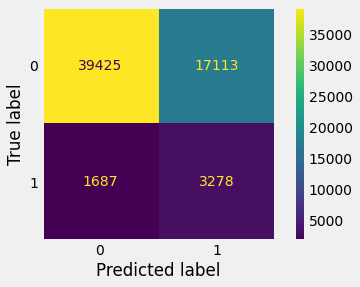


Performance Metrics for LogisticRegression(class_weight='balanced') :
Fbeta Score : 0.4072
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.6602
F1 Score : 0.2586
AUROC : 0.7357
Execution time (sec): 4.0

Best Hyperparam(s) on training set :{'C': 0.005}


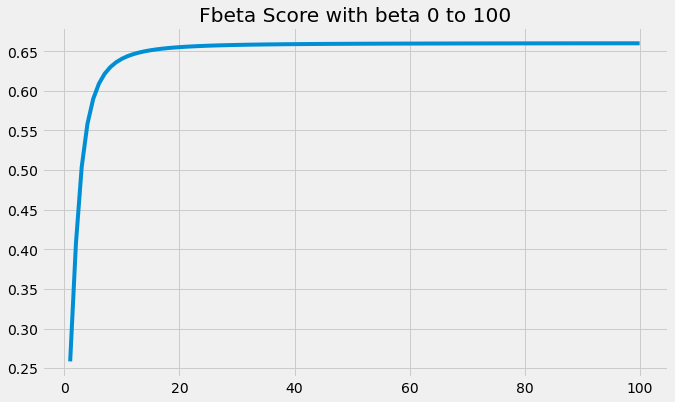

In [ ]:
model = LogisticRegression(class_weight = 'balanced')

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_bal_fe_RFECV_fb = train_test_f2(model,
                                                  2,
                                                  tuned_parameters,
                                                  X_train_tr_RFECV,
                                                  X_test_tr_RFECV,
                                                  y_train_sample,
                                                  y_test,
                                                  True)

In [ ]:
model = LogisticRegression(class_weight = 'balanced')

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_full = train_test_f2(model,
                                    20,
                                    tuned_parameters,
                                    X_train_tr_RFECV_full_reglog,
                                    X_test_tr_RFECV,
                                    y_train,
                                    y_test)

NameError: ignored

In [ ]:
model = LogisticRegression(class_weight = 'balanced')

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_bal_fe_RFECV_fb = train_test_f2(model,
                                                  20,
                                                  tuned_parameters,
                                                  X_train_tr_RFECV,
                                                  X_test_tr_RFECV,
                                                  y_train_sample,
                                                  y_test)

In [ ]:
df_results_Log_bal_fe_RFECV_fb

,Model,best_params_,roc_auc_score_train,roc_auc_score_test,recall_score_test,fbeta_score_,f1_score_test,execution_time (sec)
0,LogisticRegression(class_weight='balanced'),{'C': 0.01},0.7709,0.7329,0.653,0.648,0.2566,6.0


Confusion Matrix from predictions for LGBMClassifier(class_weight='balanced') :


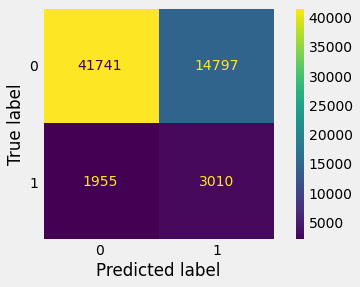


Performance Metrics for LGBMClassifier(class_weight='balanced') :
Fbeta Score : 0.6024
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.6062
F1 Score : 0.2644
AUROC : 0.7339
Execution time (sec): 293.0

Best Hyperparam(s) on training set :{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'reg_alpha': 0.0001}


In [ ]:
model = LGBMClassifier(class_weight = 'balanced') 

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM_bal_fe_RFECV_fb = train_test_f2(model,
                                                20,
                                                tuned_parameters,
                                                X_train_tr_RFECV,
                                                X_test_tr_RFECV,
                                                y_train_sample,
                                                y_test)

In [ ]:
df_results_LGBM_bal_fe['Improvements'] = 'Feature_eng'
df_results_LGBM_bal_fe_RFECV['Improvements'] = 'Feature_eng + RFECV'
df_results_LGBM_bal_fe_RFECV_fb['Improvements'] = 'FBETA : Feature_eng + RFECV'

df_results_Log_bal_fe_['Improvements'] = 'Feature_eng'
df_results_Log_bal_fe_RFECV['Improvements'] = 'Feature_eng + RFECV'
df_results_Log_bal_fe_RFECV_fb['Improvements'] = 'FBETA : Feature_eng + RFECV'

df_results_features = pd.concat([
                                 df_results_LGBM_bal_fe
                                 ,df_results_LGBM_bal_fe_RFECV
                                 ,df_results_LGBM_bal_fe_RFECV_fb
                                 ,df_results_Log_bal_fe_
                                 ,df_results_Log_bal_fe_RFECV
                                 ,df_results_Log_bal_fe_RFECV_fb

])
df_results_features

,Model,best_params_,roc_auc_score_train,roc_auc_score_test,recall_score_test,f1_score_test,execution_time (sec),Improvements,fbeta_score_
0,LGBMClassifier(class_weight='balanced'),"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7467,0.7404,0.6512,0.2606,397.0,Feature_eng,NaN
0,LGBMClassifier(class_weight='balanced'),"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7466,0.7391,0.6095,0.2688,296.0,Feature_eng + RFECV,NaN
0,LGBMClassifier(class_weight='balanced'),"{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7666,0.7339,0.6062,0.2644,293.0,FBETA : Feature_eng + RFECV,0.6024
0,LogisticRegression(class_weight='balanced'),{'C': 0.001},0.7462,0.7320,0.6491,0.2563,9.0,Feature_eng,NaN
0,LogisticRegression(class_weight='balanced'),{'C': 0.001},0.7517,0.7353,0.6556,0.2573,7.0,Feature_eng + RFECV,NaN
0,LogisticRegression(class_weight='balanced'),{'C': 0.01},0.7709,0.7329,0.6530,0.2566,6.0,FBETA : Feature_eng + RFECV,0.6480


## On the entire dataset

In [ ]:
columns_list = X_train_sample.columns.to_list()

In [ ]:
# col_to_drop_RFECV = [col for col in columns_list if col not in columns_importants_LGBM]
col_to_drop_RegLog = [col for col in columns_list if col not in columns_importants_RegLog]

In [ ]:
#Keep the client ID for later (when identification will be needed)
ID_clients_all = app_train['SK_ID_CURR']

`sklearn-pandas` can be used to keep indexes while applying pre-processing steps. Indeed Pipeline returns a numpy array which does not contain indexes. It is then impossible to identify the `SK_ID_CURR` of the client. [See more on Stackoverflow](https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num)

[Documentation](https://github.com/scikit-learn-contrib/sklearn-pandas)

[How to add multiple elements of the pipeline into `DaraFrameMapper`](https://stackoverflow.com/questions/39410776/how-to-use-imputer-in-a-dataframemapper-on-a-dataframe)

In [ ]:
def pipeline_df(x_train, x_test):
  '''
  Pre-processing outputing a dataframe instead of an array when using Pipeline. 
  It includes the following steps:
  SimpleImputer Median
  StandardScaler
  '''
  mapper = DataFrameMapper([
                          (x_train.columns, [SimpleImputer(strategy="median"),StandardScaler()])
                          ])

  scaled_features_train = mapper.fit_transform(x_train.copy())
  transformed_df_train = pd.DataFrame(scaled_features_train, index=x_train.index, columns=x_train.columns)

  scaled_features_test = mapper.transform(x_test.copy())
  transformed_df_test = pd.DataFrame(scaled_features_test, index=x_test.index, columns=x_test.columns)

  return transformed_df_train, transformed_df_test

In [ ]:
#Pre-processing pipeline on the full training set (OHE + Median_inputer)
X_train_tr_full, X_test_tr_full = pipeline_df(X_train, X_test)

In [ ]:
#Recursive feature elimination with RegLog Features
X_train_tr_RFECV_full_reglog = pd.DataFrame(data=X_train_tr_full, columns=columns_list).drop(col_to_drop_RegLog, axis=1)
X_test_tr_RFECV_full_reglog = pd.DataFrame(data=X_test_tr_full, columns=columns_list).drop(col_to_drop_RegLog, axis=1)

In [ ]:
#Recursive feature elimination with LGBM features

X_train_tr_RFECV_full_lgbm = pd.DataFrame(data=X_train_tr_full, columns=columns_list).drop(col_to_drop_RFECV, axis=1)
X_test_tr_RFECV_full_lgbm = pd.DataFrame(data=X_test_tr_full, columns=columns_list).drop(col_to_drop_RFECV, axis=1)

In [ ]:
model = LGBMClassifier(class_weight = 'balanced') 

tuned_parameters = [{'max_depth': range(2, 5), 
                    'learning_rate': [0.1, 0.01, 0.001], 
                    'n_estimators': [500], 
                    'reg_alpha': [0.0001]}]

df_results_LGBM_full = train_test_f2(model,
                                      20,
                                      tuned_parameters,
                                      X_train_tr_RFECV_full_lgbm,
                                      X_test_tr_RFECV_full_lgbm,
                                      y_train,
                                      y_test)

In [ ]:
df_results_Log_full['Improvements'] = 'Full Dataset'
df_results_LGBM_full['Improvements'] = 'Full Dataset'

In [ ]:
pd.concat([
          df_results_LGBM_full
          ,df_results_Log_full
])

In [ ]:
df_results_features_full = pd.concat([
                                 df_results_LGBM_bal_fe
                                 ,df_results_LGBM_bal_fe_RFECV
                                 ,df_results_LGBM_bal_fe_RFECV_fb
                                 ,df_results_LGBM_full
                                 ,df_results_Log_bal_fe_
                                 ,df_results_Log_bal_fe_RFECV
                                 ,df_results_Log_bal_fe_RFECV_fb
                                 ,df_results_Log_full

])
df_results_features_full

,Model,best_params_,roc_auc_score_train,roc_auc_score_test,recall_score_test,f1_score_test,execution_time (sec),Improvements,fbeta_score_
0,LGBMClassifier(class_weight='balanced'),"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7467,0.7404,0.6512,0.2606,397.0,Feature_eng,NaN
0,LGBMClassifier(class_weight='balanced'),"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7466,0.7391,0.6095,0.2688,296.0,Feature_eng + RFECV,NaN
0,LGBMClassifier(class_weight='balanced'),"{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7666,0.7339,0.6062,0.2644,293.0,FBETA : Feature_eng + RFECV,0.6024
0,LGBMClassifier(class_weight='balanced'),"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500, 'reg_alpha': 0.0001}",0.7759,0.7604,0.6673,0.2759,2649.0,Full Dataset,0.6626
0,LogisticRegression(class_weight='balanced'),{'C': 0.001},0.7462,0.7320,0.6491,0.2563,9.0,Feature_eng,NaN
0,LogisticRegression(class_weight='balanced'),{'C': 0.001},0.7517,0.7353,0.6556,0.2573,7.0,Feature_eng + RFECV,NaN
0,LogisticRegression(class_weight='balanced'),{'C': 0.01},0.7709,0.7329,0.6530,0.2566,6.0,FBETA : Feature_eng + RFECV,0.6480
0,LogisticRegression(class_weight='balanced'),{'C': 0.001},0.7498,0.7440,0.6765,0.2611,111.0,Full Dataset,0.6712


#(Threshold variation)

Our best model so far is 'LogisticRegression'. We will perform threshold variation only on this model. 

Credits: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

One approach of Threshold variation would be to test the model with each threshold returned from the call roc_curve() and select the threshold with the largest fbeat score.

In [ ]:
def best_threshold(model, x_train, y_train, x_test, y_test):
  #fit the model
  model = model
  model.fit(x_train, y_train)

  #predic probabilities
  y_proba = model.predict_proba(x_test)

  #keep proba for positive outcome only
  y_proba = y_proba[:, 1]

  #calculate AUROC
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_proba)

  #F-beta score
  fbeta_list = []

  for i in range(0, 100, 1):
    y_pred = y_proba > i/100
    fbeta = sklearn.metrics.fbeta_score(y_test, y_pred, beta=2)
    fbeta_list.append((i/100, fbeta)) 

  #locate the index of the largets fbeta score
  ix = np.argmax([i[1] for i in fbeta_list]) #argmax : Returns the indices of the maximum values along an axis. 
  fbeta = fbeta_list[ix][1]
  threshold = fbeta_list[ix][0]

  #https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
  print('Best Threshold=%f, Fbeta=%.3f' % (threshold, fbeta))

  #plot AUROC with best Threshold
  plt.plot([i[0] for i in fbeta_list], [i[1] for i in fbeta_list], linestyle='solid', label='LogisticRegression')
  plt.scatter(threshold, fbeta, marker='o', color='black', label="Best (F-Beta)")

  #axis labels
  plt.xlabel('Threshold')
  plt.ylabel('F-Beta')
  plt.legend()

  #show plot
  plt.show()

  return threshold

Best Threshold=0.480000, Fbeta=0.409


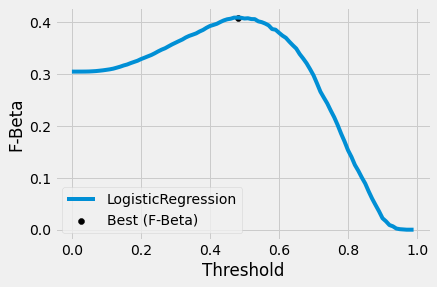

In [ ]:
model = LogisticRegression(class_weight = 'balanced', C= 0.001)

best_threshold_LogReg = best_threshold(model,
                                       X_train_tr_RFECV_full_reglog,
                                       y_train,
                                       X_test_tr_RFECV_full_reglog,
                                       y_test)

Let's now include a new `threshold` parameter in our `train_test` function : 

In [ ]:
def train_test_fin (model, beta, threshold, tuned_parameters, x_train, x_test, y_train, y_test, beta_search=None):
  
  #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
  #https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308256-evaluez-un-algorithme-de-classification-qui-retourne-des-valeurs-binaires
  print(tuned_parameters)

  scorer = make_scorer(fbeta_score, beta=beta)

  clf = GridSearchCV(model, 
                    param_grid=tuned_parameters, 
                    scoring=scorer, 
                    refit=True,
                    cv=5,
                    return_train_score=True
                    )
  clf.fit(x_train, y_train)
  
  y_pred_train_proba = clf.best_estimator_.predict_proba(x_train) 
  y_pred_train_proba = y_pred_train_proba[:, 1]

  y_pred_proba = clf.best_estimator_.predict_proba(x_test) 
  y_pred_proba = y_pred_proba[:, 1]
  y_pred = y_pred_proba > threshold
  y_pred = y_pred.astype(int)

  #confusion matrix from predictions
  print(f'Confusion Matrix from predictions for {model} :')
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.grid(False)
  plt.show()
  print()

  #performance metrics on test set
  recall_score = round(sklearn.metrics.recall_score(y_test, y_pred),4)
  f1_score = round(sklearn.metrics.f1_score(y_test, y_pred),4)
  roc_auc_score_train = round(sklearn.metrics.roc_auc_score(y_train, y_pred_train_proba),4)
  roc_auc_score = round(sklearn.metrics.roc_auc_score(y_test, y_pred_proba),4)
  fbeta_score_ = round(sklearn.metrics.fbeta_score(y_test, y_pred, beta=beta),4)

  #execution time
  mean_fit_time = clf.cv_results_['mean_fit_time']
  mean_score_time = clf.cv_results_['mean_score_time']
  n_splits = clf.n_splits_ #number of splits of training data
  n_iter = pd.DataFrame(clf.cv_results_).shape[0] #Iterations it takes per split for the solver to converge 
  execution_time = round(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter, 0)

  #return (i) perf metrics (ii) best hyperparams
  print(f'Best Threshold : {threshold} ')
  print(f'Performance Metrics for {model} :')
  print(f'Fbeta Score : {fbeta_score_}')
  print(f'Recall/sensitivity [true positive rate = TP / (TP + FN)]: {recall_score}')
  print(f'F1 Score : {f1_score}')
  print(f'AUROC : {roc_auc_score}')
  print(f'Execution time (sec): {execution_time}')
  print()

  print(f'Best Hyperparam(s) on training set :{clf.best_params_}')

  # store results in a dataframe
  df_results = pd.DataFrame(columns=['Model',
                                     'best_params_', 
                                     'roc_auc_score_train', 
                                     'roc_auc_score_test', 
                                     'recall_score_test',
                                     'fbeta_score_',
                                     'f1_score_test',
                                     'execution_time (sec)'
                                     ])

  data = {'Model': [model], 
          'best_params_' : [clf.best_params_], 
          'roc_auc_score_train' : [roc_auc_score_train],
          'roc_auc_score_test' : [roc_auc_score],
          'recall_score_test' : [recall_score], 
          'fbeta_score_' : [fbeta_score_], 
          'f1_score_test': [f1_score], 
          'execution_time (sec)': [execution_time]
          }

  results = pd.DataFrame.from_dict(data)

  df_results = df_results.append(results)
  
  if beta_search == True:

    beta_score_list = []
    for i in range(1,101):
        fbeta_results = fbeta_score(y_test,y_pred,beta=i)
        beta_score_list.append(fbeta_results)

    fig = plt.figure(figsize=(10,6))
    sns.lineplot(x=range(1,101), y=beta_score_list)
    plt.title('Fbeta Score with beta 0 to 100')

  return df_results

[{'C': [0.01, 0.001, 0.005]}]
Confusion Matrix from predictions for LogisticRegression(class_weight='balanced') :


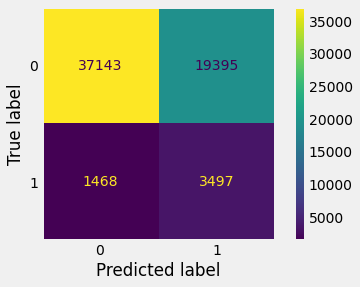


Best Threshold : 0.48 
Performance Metrics for LogisticRegression(class_weight='balanced') :
Fbeta Score : 0.698
Recall/sensitivity [true positive rate = TP / (TP + FN)]: 0.7043
F1 Score : 0.2511
AUROC : 0.7397
Execution time (sec): 81.0

Best Hyperparam(s) on training set :{'C': 0.01}


In [ ]:
best_threshold_LogReg = 0.48

model = LogisticRegression(class_weight = 'balanced')

tuned_parameters = [
  {'C': [0.01, 0.001, 0.005]}
  ]

df_results_Log_fin_ = train_test_fin(model,
                                    20,
                                    best_threshold_LogReg,
                                    tuned_parameters,
                                    X_train_tr_RFECV_full_reglog,
                                    X_test_tr_RFECV_full_reglog,
                                    y_train,
                                    y_test)


In [ ]:
df_results_Log_fin_

,Model,best_params_,roc_auc_score_train,roc_auc_score_test,recall_score_test,fbeta_score_,f1_score_test,execution_time (sec)
0,LogisticRegression(class_weight='balanced'),{'C': 0.01},0.7444,0.7397,0.7043,0.698,0.2511,81.0


# Model Interpretation

[credits](https://medium.com/codex/global-modular-interpretation-of-credit-scoring-model-using-logistic-regression-422db15f0e8a)

**What is Interpretability?**

Interpretability is the extent to which humans, including non-subject-matter experts, can understand the cause and effect, and input and output, of a machine learning model. To say a model has a high level of interpretability means you can describe in a human interpretable way its inference. 

- In other words, why does an input to a model produce a specific output? 

- What are the requirements and constraints of the input data? 

- What are the confidence bounds of the predictions? Or, why does one variable have a more substantial effect than another? 

For interpretability, detailing how a model works is only relevant to the extent that it can explain its predictions and justify that it’s the right model for the use case.


**What is Explainability?**

Explainability encompasses everything interpretability is. The difference is that it goes deeper on the transparency requirement than interpretability because it demands human friendly explanations for a **model’s inner workings and the model training process**, and not just model inference. 

Depending on the application, this requirement might extend to various degrees of model, design, and algorithmic transparency.

**Approach**

Logistic regression is one common way to rank risk factors in financial use cases. 

Unlike linear regression, It doesn’t try to predict a continuous value for each of your observations, but it predicts a **probability score that an observation belongs to a particular class**. In this case, what we are trying to predict is, given x data for each loan applicant, what is the probability, from 0 to 1, that they will default on loan repayment.

## Global interpretation

[Inria MOOC](https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html)

The objective of Global interpretation is to obtain a global understanding of the features importance. 

In [ ]:
model = LogisticRegression(class_weight = 'balanced', C=0.005)

model.fit(X_train_tr_RFECV_full_reglog, y_train)

LogisticRegression(C=0.005, class_weight='balanced')

In [ ]:
coefs = pd.DataFrame(
    model.coef_[0],
    columns=['Coefficients'], index=X_train_tr_RFECV_full_reglog.columns
)

In [ ]:
coefs = coefs.reindex(coefs['Coefficients'].abs().sort_values(ascending=True).index)

The coefficients of a linear model are a **conditional association:** they quantify the variation of the output (the default proba) when the given feature varies, keeping all other features constant. 

We **should not interpret them as a marginal association**, characterizing the link between the two quantities ignoring all the rest.

Text(0.5, 1.0, 'Logistic Regression Model')

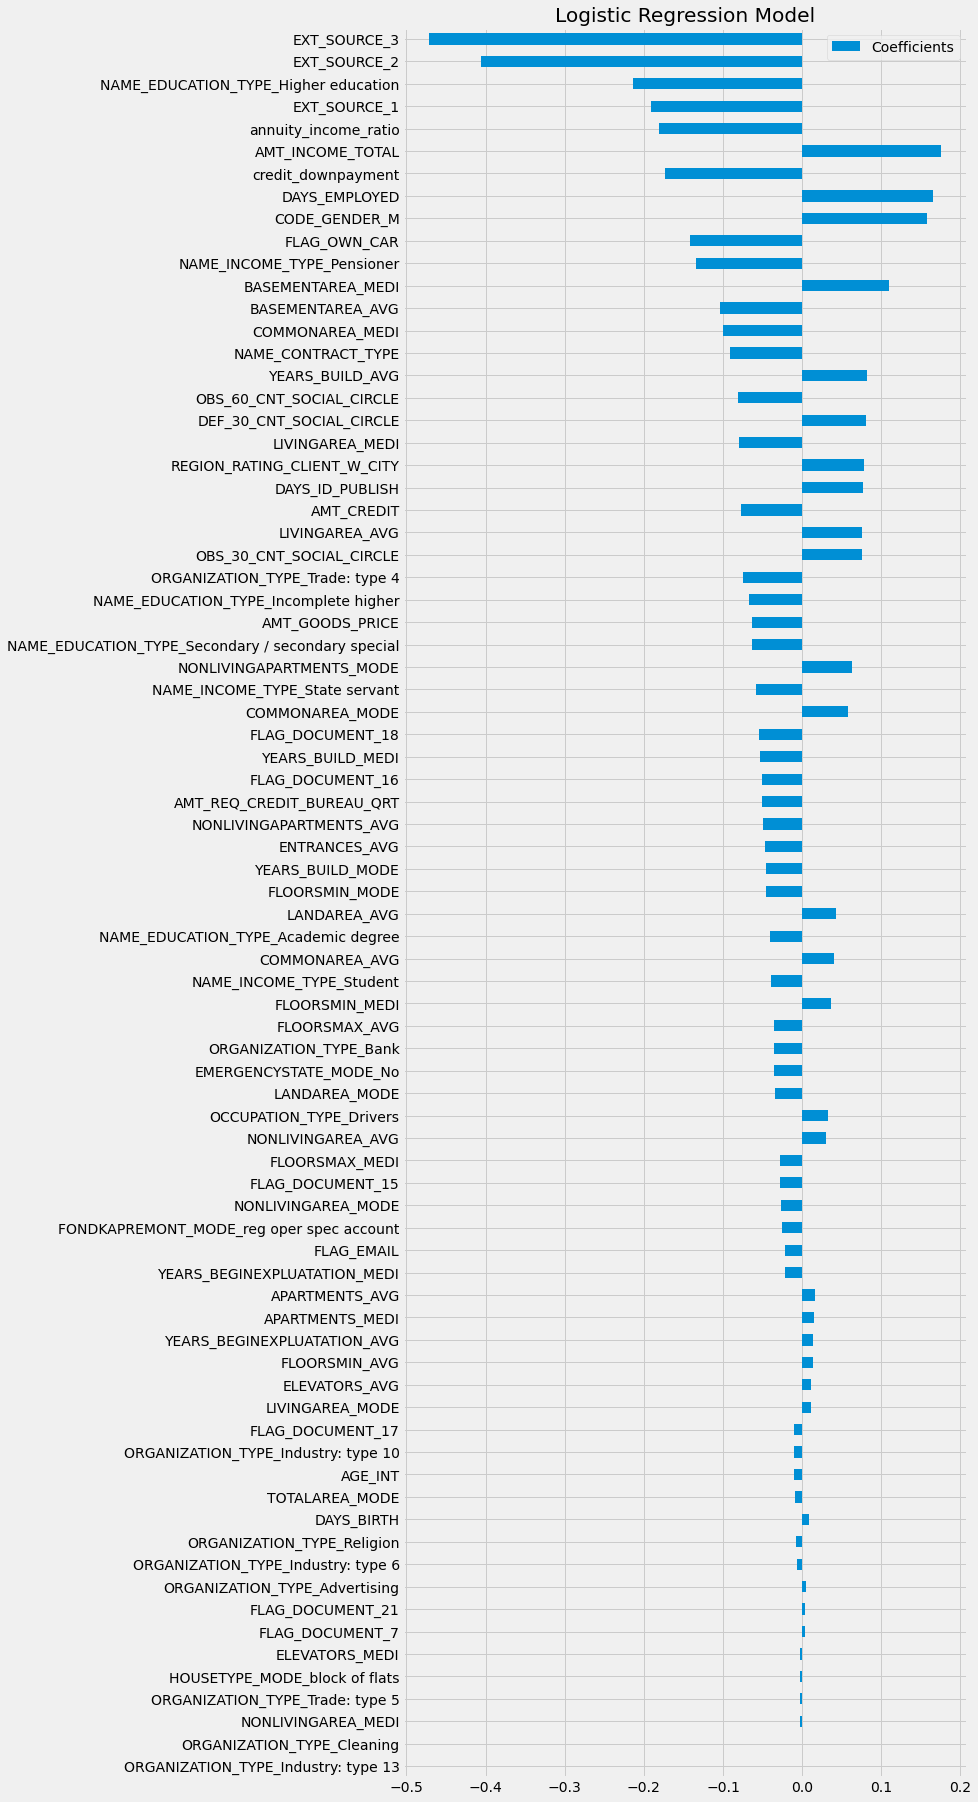

In [ ]:
coefs.plot(kind='barh', figsize=(9,30))
plt.title('Logistic Regression Model')

As we see our data is scaled (mean around 0, and std around 1), we can compare the coefficients plotted. 

In [ ]:
# Description data
descriptions = pd.read_csv(path + '/HomeCredit_columns_description.csv', encoding='utf-8', encoding_errors='ignore')

In [ ]:
top10_features = coefs.iloc[-10:,:]

In [ ]:
df_top10_features = top10_features.merge(descriptions[descriptions['Table']=='application_{train|test}.csv'], how='inner', left_index=True, right_on='Row').sort_values(by='Coefficients')

In [ ]:
df_top10_features.drop(['Unnamed: 0', 'Table', 'Special'], axis=1, inplace=True)
df_top10_features.reset_index(inplace=True)
df_top10_features.drop(['index'], axis=1, inplace=True)

In [ ]:
df_top10_features['Odds Ratio'] = np.exp(df_top10_features['Coefficients'])
df_top10_features

,Coefficients,Row,Description,Odds Ratio
0,-0.471727,EXT_SOURCE_3,Normalized score from external data source,0.623924
1,-0.405912,EXT_SOURCE_2,Normalized score from external data source,0.666369
2,-0.190392,EXT_SOURCE_1,Normalized score from external data source,0.826635
3,-0.141478,FLAG_OWN_CAR,Flag if the client owns a car,0.868074
4,0.165801,DAYS_EMPLOYED,How many days before the application the person started current employment,1.180338
5,0.175907,AMT_INCOME_TOTAL,Income of the client,1.192327


Negative coefficients can be interpreted as: 

- the strongest the value of the input is, the less likely the output to be positive (default) : 

  - `EXTRERNAL SOURCES` : no information on theses variables 
  - `AMT_GOODS_PRICE`: the highest the amount of the good to be financed, the less likely to default
  - `CAR_OWN`


Positive coefficients can be interpreted as: 
- the strongest the value of the input is, the more likely the output to be positive (default):
  - `BASEMENTAREA_MEDI`: is the client currently living in a place where most of the surface corresponds to basement
  - `AMT_ANNUITY`: the biggest the annuity (considering other variables as stable) the more likely to default
  - `DAYS_EMPLOYED`: before scaling we observed this variables starts from 0. The biggest this value is, the more likely is the default. In other words, people that have been employed for less longer are more likely to default.

As the model we are considering is Logistic Regression, a change in a feature by one unit changes the odds ratio (multiplicative) by a factor of  $$exp(βj)$$

[Credits: Interpretable ML](https://christophm.github.io/interpretable-ml-book/logistic.html)

## Local Interpretation

L’approche SHAP est additive, donc une prédiction peut être écrite comme la somme des différents effets des variables à laquelle on ajoute la valeur de base du model. [SHAP intro (FR)](https://www.aquiladata.fr/insights/shap-mieux-comprendre-linterpretation-de-modeles/)

As we are going to perform a local interpretation, Client ID will be useful to analyze the results: 

[Notebook example](https://colab.research.google.com/drive/1pjPzsw_uZew-Zcz646JTkRDhF2GkPk0N#scrollTo=mFzyPAn5veDn)

The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

Let's try SHAP explainer on `LogisticRegression` as described by the creators [here](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html)

In [ ]:
model = LogisticRegression(class_weight = 'balanced', C=0.005)

model.fit(X_train_tr_RFECV_full_reglog, y_train)

coefs = pd.DataFrame(
    model.coef_[0],
    columns=['Coefficients'], index=X_train_tr_RFECV_full_reglog.columns
)

coefs = coefs.reindex(coefs['Coefficients'].abs().sort_values(ascending=True).index)

In [ ]:
explainer = shap.Explainer(model, 
                           X_train_tr_RFECV_full_reglog, 
                           feature_names=X_train_tr_RFECV_full_reglog.columns)

shap_values = explainer(X_test_tr_RFECV_full_reglog)

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

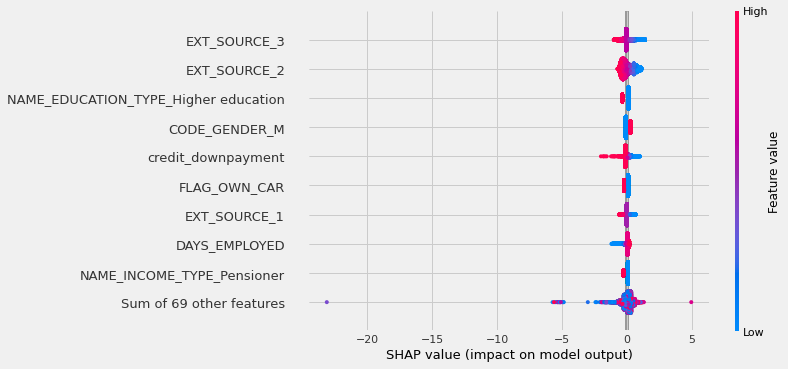

In [ ]:
#print a summary plot
shap.plots.beeswarm(shap_values)

You can visualize feature attributions such as Shapley values as “forces”. Each feature value is a force that either increases or decreases the prediction. The prediction starts from the baseline. 

**The baseline for Shapley values is the average of all predictions (i.e the average model output over the training dataset we passed)**. In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. These forces balance each other out at the actual prediction of the data instance.

In [ ]:
X_train_tr_RFECV_full_reglog = X_train_tr_RFECV_full_reglog.merge(ID_clients_all, how='inner', left_index=True, right_index=True)
X_test_tr_RFECV_full_reglog = X_test_tr_RFECV_full_reglog.merge(ID_clients_all, how='inner', left_index=True, right_index=True)

In [ ]:
X_test_tr_RFECV_full_reglog.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,...,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,EMERGENCYSTATE_MODE_No,annuity_income_ratio,credit_downpayment,AGE_INT,SK_ID_CURR
61614,-0.323544,-0.718009,-0.181739,-0.817851,-0.847717,0.631308,0.609474,0.535960,-0.246298,1.924814,...,-0.016131,-0.01454,-0.012911,-0.202201,-0.979886,-1.038225,-0.160744,0.232585,0.634135,171458
97858,-0.323544,-0.718009,-0.268294,-0.179827,-0.226456,0.779485,-0.356544,0.003818,-0.246298,-0.063737,...,-0.016131,-0.01454,-0.012911,-0.202201,-0.979886,-1.038225,-0.166350,-0.156757,0.801344,213619
30931,-0.323544,-0.718009,-0.129806,-0.369766,-0.238637,-0.020259,0.736188,1.256968,-0.246298,-0.063737,...,-0.016131,-0.01454,-0.012911,-0.202201,1.020527,0.963183,-0.346627,0.864674,-0.034704,135905
211436,-0.323544,1.392740,-0.043251,-0.857117,-0.835536,-0.293482,-2.022528,-1.022029,-0.246298,-0.063737,...,-0.016131,-0.01454,-0.012911,-0.202201,1.020527,0.963183,-0.099156,0.520792,-0.285519,345017
47772,-0.323544,-0.718009,-0.458715,-0.807704,-0.786809,1.396928,0.283104,-1.064441,-0.246298,-0.063737,...,-0.016131,-0.01454,-0.012911,-0.202201,1.020527,0.963183,-0.409449,0.493848,1.386578,155332


In [ ]:
#to visualize in the notebook
shap.initjs()

#explain the first item prediction
ind = 1

shap.plots.force(shap_values[ind])


In [ ]:
#to visualize in the notebook
shap.initjs()

#explain the first item prediction
shap.plots.force(shap_values[61614])

In [ ]:
print("Default" if y_test_reset.iloc[61477,1] else "Solvent")
X_test_tr_RFECV_full_reglog.iloc[61477,:]

Default


SK_ID_CURR                                 -1.495355
NAME_CONTRACT_TYPE                         -0.327786
FLAG_OWN_CAR                                1.393666
AMT_CREDIT                                 -0.710758
AMT_ANNUITY                                -0.731983
                                              ...   
ORGANIZATION_TYPE_Industry: type 6         -0.020166
ORGANIZATION_TYPE_Religion                 -0.018481
ORGANIZATION_TYPE_Trade: type 4            -0.013970
ORGANIZATION_TYPE_Trade: type 5            -0.011406
FONDKAPREMONT_MODE_reg oper spec account   -0.202253
Name: 61477, Length: 74, dtype: float64

In [ ]:
print("Default" if y_test_reset.iloc[ind,1] else "Solvent")
X_test_tr_RFECV_full_reglog.iloc[ind,:]

Solvent


SK_ID_CURR                                 -1.042856
NAME_CONTRACT_TYPE                         -0.327786
FLAG_OWN_CAR                               -0.717532
AMT_CREDIT                                 -0.821579
AMT_ANNUITY                                -0.405916
                                              ...   
ORGANIZATION_TYPE_Industry: type 6         -0.020166
ORGANIZATION_TYPE_Religion                 -0.018481
ORGANIZATION_TYPE_Trade: type 4            -0.013970
ORGANIZATION_TYPE_Trade: type 5            -0.011406
FONDKAPREMONT_MODE_reg oper spec account   -0.202253
Name: 0, Length: 74, dtype: float64

In [ ]:
ind = 24
shap.initjs()
shap.plots.force(shap_values[ind])

In [ ]:
descriptions[descriptions['Row']=='OBS_60_CNT_SOCIAL_CIRCLE']

,Unnamed: 0,Table,Row,Description,Special
93,96,application_{train|test}.csv,OBS_60_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings with observable 60 DPD (days past due) default,NaN


In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
X_test_tr_RFECV_full_reglog.iloc[ind,0]

0.9476167609425087

In [ ]:
app_train[app_train['SK_ID_CURR']==9476167609425087]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


In [ ]:
print("Default" if y_test_reset.iloc[ind,1] else "Solvent")
X_test_tr_RFECV_full_reglog.iloc[ind,:]

Default


SK_ID_CURR                                           0.947617
NAME_CONTRACT_TYPE                                  -0.327786
FLAG_OWN_CAR                                        -0.717532
AMT_CREDIT                                          -0.293818
AMT_ANNUITY                                          0.609896
AMT_GOODS_PRICE                                     -0.229016
DAYS_EMPLOYED                                       -1.166429
DAYS_ID_PUBLISH                                     -0.926409
FLAG_EMAIL                                          -0.240846
REGION_RATING_CLIENT_W_CITY                         -0.058541
EXT_SOURCE_1                                         0.258102
EXT_SOURCE_2                                        -0.346269
EXT_SOURCE_3                                        -1.247444
BASEMENTAREA_AVG                                     0.653812
YEARS_BEGINEXPLUATATION_AVG                          0.239170
YEARS_BUILD_AVG                                      1.677606
COMMONAR